In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [7]:
from tensorflow.keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

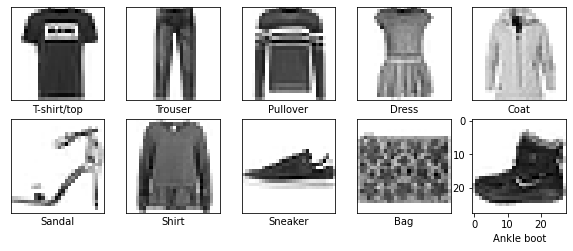

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

_, indicesList = np.unique(y_train, return_index=True)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5,5,i+1)
#     plt.grid(False)
    plt.imshow(x_train[indicesList[i]] , cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

In [9]:
def sigmoid(x):
    x = np.clip(x, a_min = -700, a_max = 700)
    return (1/(1+ np.exp(-x)))

def sigmoid_grad(x):
    a = sigmoid(x)
    return a*(1-a)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    a = tanh(x)
    return 1 - a*a

def relu(x):
    x[x<0] = 0
    return x

def relu_grad(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def linear(x):
    return x

def linear_grad(x):
    return np.ones(x.shape)

# def softmax(x):
#     exps = np.exp(x)
#     exps_sum = np.sum(exps,axis=0,keepdims=True)
#     return exps/exps_sum

# def softmax_grad(x):
#     soft = softmax(x)
    
    

In [10]:
activations = {
    "sigmoid": [sigmoid,sigmoid_grad],
    "tanh": [tanh,tanh_grad],
    "relu": [relu,relu_grad],
    "linear": [linear,linear_grad]
}

In [11]:
def cross_entropy_loss(real,pred):
    ret = np.multiply(real,pred)
    loss = -np.mean(np.log(np.sum(ret,axis=1)+1e-8))
    return loss

def cross_entropy_loss_grad(real,pred):
    return pred-real

def mse_loss(real,pred):
    ret = np.mean((pred-real)**2)/2
    return ret
    
def mse_loss_grad(real,pred):
    return pred-real

In [12]:
losses = {
    "cross_entropy":(cross_entropy_loss,cross_entropy_loss_grad),
    "mse": (mse_loss,mse_loss_grad)
}

In [13]:
class initializer:
    
    def normal(inputs,outputs):
        weights = np.random.randn(inputs,outputs)
        bias = np.random.randn(outputs,)
        return weights,bias
    
    def xavier(inputs,outputs):
        scale = 1/max(1.,(inputs+outputs)/2.)
        limit = math.sqrt(3.0*scale)
        weights = np.random.uniform(-limit,limit,size=(inputs,outputs))
        bias = np.random.uniform(-limit,limit,size=(outputs,))
        return weights,bias
    

In [14]:
weight_inits = {
    "random": initializer.normal,
    "xavier": initializer.xavier
}

In [56]:
class layer:
    
    def __init__(self,neurons,inputs,activation = "sigmoid",weight_init="random"):
        self.W,self.b = weight_inits[weight_init](inputs,neurons)
        self.neurons = neurons
        self.inputs = inputs
        self.activation = activations[activation]
        
            
    def run_layer(self,A):
        a = A @ self.W +self.b      #a is not dot product
        self.inp = A
        return self.activation[0](a)
    
    def back_pass(self,dl_da,lr=0.1,lamda=0.0):
        h = self.inp @ self.W + self.b
        da_dh = self.activation[1](h)
        temp = np.multiply(dl_da,da_dh)
        dl_dw = self.inp.T @ temp + lamda * self.W
        dl_db = np.sum(temp,axis=0) + lamda * self.b
        dl_dx = temp @ self.W.T
        
        return dl_dx, dl_dw, dl_db
    

In [57]:
def find_accuracy(pred,real):
    a = np.argmax(pred,axis=1)
    b = np.argmax(real,axis=1)
    return np.mean(a==b)

In [113]:
def logging(model,inputs,outputs,xval,yval):

    train_accuracy = find_accuracy(model.predict(inputs),outputs)
    val_accuracy = find_accuracy(model.predict(xval),yval)

    train_loss = model.loss[0](model.predict(inputs),outputs)
    val_loss = model.loss[0](model.predict(xval),yval)
    wandb.log({"train accuracy": train_accuracy,"validation accuracy": val_accuracy,"train loss": train_loss,"val loss": val_loss})

In [132]:
class optimizers:
    
    def sgd(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1):
        best_acc = 0.0
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    lay.W -= lr * dw / batch_size
                    lay.b -= lr * db / batch_size
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                logging(model,inputs,outputs,xval,yval)
                         
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def momentum(model, inputs, outputs,val=None,epochs = 1, lr = 0.1, batch_size = 1,gamma = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    v_w[k] = gamma * v_w[k] + lr * dw
                    v_b[k] = gamma * v_b[k] + lr * db
                    
                    lay.W -= v_w[k]
                    lay.b -= v_b[k]
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def nesterov(model, inputs, outputs,val=None,epochs = 1, lr = 0.1, batch_size = 1,gamma = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                model1 = copy.copy(model)
                
                for k,lay in enumerate(model1.layers):
                    lay.W -= gamma * v_w[k]
                    lay.b -= gamma * v_b[k]
                
                grads = model1.find_gradient(inps,outs)
                        
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    v_w[k] = gamma * v_w[k] + lr * dw
                    v_b[k] = gamma * v_b[k] + lr * db
                    
                    lay.W -= v_w[k]
                    lay.b -= v_b[k]
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def rmsprop(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9):
        eps = 1e-8
        best_acc = 0.0
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    v_w[k] = beta1 * v_w[k] + (1-beta1) * dw**2
                    v_b[k] = beta1 * v_b[k] + (1-beta1) * db**2
                    
                    lay.W -= (lr / np.sqrt(v_w[k] + eps)) * dw
                    lay.b -= (lr / np.sqrt(v_b[k] + eps)) * db
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    def adam(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9,beta2 = 0.999,lamda=0.0):
        eps = 1e-8
        best_acc = 0.0
        m_w = [np.zeros(la.W.shape) for la in model.layers]
        m_b = [np.zeros(la.b.shape) for la in model.layers]
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    m_w[k] = beta1 * m_w[k] + (1-beta1) * dw
                    m_b[k] = beta1 * m_b[k] + (1-beta1) * db
                    
                    v_w[k] = beta2 * v_w[k] + (1-beta2) * dw**2
                    v_b[k] = beta2 * v_b[k] + (1-beta2) * db**2
                    
                    m_w_hat = m_w[k]/(1-math.pow(beta1,i+1))
                    m_b_hat = m_b[k]/(1-math.pow(beta1,i+1))
                    
                    v_w_hat = v_w[k]/(1-math.pow(beta2,i+1))
                    v_b_hat = v_b[k]/(1-math.pow(beta2,i+1))
                    
                    lay.W -= (lr / np.sqrt(v_w_hat + eps)) * m_w_hat
                    lay.b -= (lr / np.sqrt(v_b_hat + eps)) * m_b_hat
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
            
            
        return model
    
    
    def nadam(model, inputs, outputs,val=None,epochs = 1, lr = 0.01, batch_size = 1,beta1 = 0.9,beta2 = 0.999):
        eps = 1e-8
        best_acc = 0.0
        m_w = [np.zeros(la.W.shape) for la in model.layers]
        m_b = [np.zeros(la.b.shape) for la in model.layers]
        v_w = [np.zeros(la.W.shape) for la in model.layers]
        v_b = [np.zeros(la.b.shape) for la in model.layers]
        for i in range(epochs):
            for j in range(0,inputs.shape[0],batch_size):
                inps = inputs[j:min(inputs.shape[0],j+batch_size)]
                outs = outputs[j:min(inputs.shape[0],j+batch_size)]
                
                grads = model.find_gradient(inps,outs)
                
                for k,lay in enumerate(model.layers):
                    dw,db = grads[k]
                    dw /= batch_size
                    db /= batch_size
                    
                    m_w[k] = beta1 * m_w[k] + (1-beta1) * dw
                    m_b[k] = beta1 * m_b[k] + (1-beta1) * db
                    
                    v_w[k] = beta2 * v_w[k] + (1-beta2) * dw**2
                    v_b[k] = beta2 * v_b[k] + (1-beta2) * db**2
                    
                    m_w_hat = m_w[k]/(1-math.pow(beta1,i+1))
                    m_b_hat = m_b[k]/(1-math.pow(beta1,i+1))
                    
                    v_w_hat = v_w[k]/(1-math.pow(beta2,i+1))
                    v_b_hat = v_b[k]/(1-math.pow(beta2,i+1))
                    
                    bcalc = (1-beta1)/(1-math.pow(beta1,i+1))
                    
                    lay.W -= (lr / np.sqrt(v_w_hat + eps)) * ( beta1 * m_w_hat + bcalc * dw)
                    lay.b -= (lr / np.sqrt(v_b_hat + eps)) * ( beta1 * m_b_hat + bcalc * db)
                    
            pred = model.predict(inputs)
            regularization = sum([np.sum(lay.W**2)+np.sum(lay.b**2) for lay in model.layers])
            loss = model.loss[0](outputs,pred) + regularization * model.lamda / 2
            
            if val is not None:
                xval,yval = val
                acc = find_accuracy(model.predict(xval),yval)
                if acc >= best_acc:
                    best_acc = acc
                    best_model = model
                    
                logging(model,inputs,outputs,xval,yval)
                    
            print("Epoch {} done: Loss = {}".format(i,loss))
            
        if val is not None:
            model = best_model
        return model

In [133]:
opts = {
    "sgd": optimizers.sgd,
    "rmsprop": optimizers.rmsprop,
    "adam": optimizers.adam,
    "nadam": optimizers.nadam,
    "momentum": optimizers.momentum,
    "nesterov": optimizers.nesterov
}

In [134]:
class models:
    
    def __init__(self,inputs,loss="cross_entropy",optimizer="sgd",lamda=0.0):
        self.inputs = inputs
        self.layers = []
        self.loss = losses[loss]
        self.optimizer = opts[optimizer]
        self.opt_name = optimizer
        self.lamda = lamda
        
        
    def add_layer(self,neurons,weight_init="random",activation=None):
        if len(self.layers) == 0:
            inps = self.inputs
        else:
            inps = self.layers[-1].neurons
        new_layer = layer(neurons,inps,activation,weight_init=weight_init)
        self.layers.append(new_layer)
        
        
    def forward_pass(self,inputs):
        res = inputs
        for lay in self.layers:
            res = lay.run_layer(res)
            
        return res
    
    def print(self):
        for lay in self.layers:
            print("Layer : ")
            print("Input: {}".format(lay.inputs))
            print("Neurons: {}".format(lay.neurons))
            
    def backward_pass(self,dl_da):
        dd = dl_da
        grads = []
        for lay in reversed(self.layers) :
            dd,dw,db = lay.back_pass(dd,lamda=self.lamda)
            grads.append((dw,db))
            
        return grads[::-1]
    
    def find_gradient(self,inputs,outputs):
        pred = self.forward_pass(inputs)
        dl_dout = self.loss[1](outputs,pred)
        grads = self.backward_pass(dl_dout)
        return grads
    
    def predict(self,inputs):
        pred = self.forward_pass(inputs)
        return np.array(pred)
    
        
    def train(self,inputs,outputs,val=None,lr=0.01,batch_size=1,epochs=1,v_w=0,v_b=0,beta1=0.9,beta2=0.999,gamma=0.9):
        if self.opt_name == "sgd":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,
                                   batch_size=batch_size)
            
        elif self.opt_name == "momentum":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   gamma=gamma)
            
        
        elif self.opt_name == "nesterov":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   gamma=gamma)
            
        elif self.opt_name == "rmsprop":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1)
            
        elif self.opt_name == "adam":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1,beta2=beta2)
            
        elif self.opt_name == "nadam":
            model = self.optimizer(self,inputs,outputs,val=val,epochs=epochs,lr=lr,batch_size=batch_size,
                                   beta1=beta1,beta2=beta2)
            
        return model
            

In [135]:
def transx(x):
    l,b,h = x.shape
    xt = x.reshape((l,b*h))
    xt = xt/np.max(xt)
    return xt

In [136]:
xt = transx(x_train)

In [137]:
def one_hot_encoding(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

yt = one_hot_encoding(y_train)
print(yt.shape)

(60000, 10)


In [141]:
# model = models(784,optimizer="momentum")
# model.add_layer(32,activation="sigmoid",weight_init="xavier")
# model.add_layer(len(class_names),activation="sigmoid")
# model.print()

In [142]:
# trained = model.train(xt,yt,epochs = 10, batch_size = 64)

In [143]:
xte = transx(x_test)
#pred = np.argmax(trained.predict(xte),axis=1)

In [144]:
#print(np.sum(pred==y_test)/y_test.shape[0])

In [145]:
import wandb

In [154]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'validation accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'hidden_layers': {
            'values': [3,4,5]
        },
        'hidden_layer_size' : {
            'values' : [32,64,128]
        },
        'lr': {
            'values': [1e-3]
        },
        'optimiser': {
            'values': ["momentum","nesterov","rmsprop","adam","nadam"]
        },
        'batch_size': {
            'values': [16,32,64]
        },
        'weight_init': {
            'values': ["xavier"]
        },
        'activation': {
            'values': ["sigmoid","tanh","relu"]
        },
        'weight_decay': {
            'values': [0,0.0005,0.5]
        }
    }
}


In [155]:
wandb.login()

True

In [156]:
sweep_id = wandb.sweep(sweep_config,entity = "notarchana" , project = "cs6910-A1")

Create sweep with ID: lzmcss02
Sweep URL: https://wandb.ai/notarchana/CS6910-A1/sweeps/lzmcss02


In [157]:
from sklearn.model_selection import train_test_split

In [159]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'hidden_layers': 3,
        'lr': 1e-3,
        'activation': "sigmoid",
        'optimiser': "sgd",
        'batch_size': 32,
        'weight_init' : "random"
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults,name="hello")
    
    config = wandb.config
    
    name = f'hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_lr_{config.lr}_opt_{config.optimiser}_winit_{config.weight_init}_wd_{config.weight_decay}'
    wandb.run.name = name
    wandb.run.save()
    
    # Config is a variable that holds and saves hyperparameters and inputs
    
    # Splitting test data for cv
    xtrain, xval,ytrain,yval = train_test_split(xt,yt,test_size = 0.2)
    
    model = models(784,optimizer = config.optimiser)
    for i in range(config.hidden_layers) :
      model.add_layer(config.hidden_layer_size,weight_init=config.weight_init,activation=config.activation)

    model.add_layer(len(class_names),activation="sigmoid",weight_init=config.weight_init)
    print("model building done")
    yte = one_hot_encoding(y_test)
    trained = model.train(xtrain,ytrain,val=(xval,yval),lr=config.lr,batch_size=config.batch_size,epochs=config.epochs)

    print("model training done")


In [160]:
np.random.seed(42)

In [161]:
wandb.agent(sweep_id, train,count=100)

wandb: Agent Starting Run: iejyeosp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 18.23444541243299
Epoch 1 done: Loss = 18.230901236092542
Epoch 2 done: Loss = 18.22712894034692
Epoch 3 done: Loss = 18.22310125906368
Epoch 4 done: Loss = 18.218786717449476
Epoch 5 done: Loss = 18.214145823857894
Epoch 6 done: Loss = 18.209131669429034
Epoch 7 done: Loss = 18.20368660782642
Epoch 8 done: Loss = 18.197740220485375
Epoch 9 done: Loss = 18.191203556312864
model training done


train accuracy,0.09963
validation accuracy,0.1015
train loss,18.1912
val loss,18.18207
_runtime,18
_timestamp,1615451865
_step,9


train accuracy,█▃▁▁▁▁▁▁▁▁
validation accuracy,█▃▁▁▁▁▁▁▁▁
train loss,█▇▇▆▅▅▄▃▂▁
val loss,█▇▇▆▅▅▄▃▂▁
_runtime,▁▁▂▃▃▅▅▇▇█
_timestamp,▁▁▂▃▃▅▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: p2plaiir with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.46313882769735887
Epoch 1 done: Loss = 0.40309527512554266
Epoch 2 done: Loss = 0.36998815679543
Epoch 3 done: Loss = 0.3524449670931081
Epoch 4 done: Loss = 0.3392698939823434
Epoch 5 done: Loss = 0.32914151687182275
Epoch 6 done: Loss = 0.31844097707709756
Epoch 7 done: Loss = 0.30907092992625945
Epoch 8 done: Loss = 0.30066239659268174
Epoch 9 done: Loss = 0.28569005393760954
model training done


train accuracy,0.90804
validation accuracy,0.88567
train loss,0.28569
val loss,0.34429
_runtime,186
_timestamp,1615452058
_step,9


train accuracy,▁▃▄▅▅▆▆▇▇█
validation accuracy,▁▃▅▅▅▆▆▇▇█
train loss,█▆▄▄▃▃▂▂▂▁
val loss,█▅▄▃▂▂▂▂▂▁
_runtime,▁▁▂▃▄▅▅▆▇█
_timestamp,▁▁▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rsceyb9y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.39056230243209983
Epoch 1 done: Loss = 0.35156656567531386
Epoch 2 done: Loss = 0.3298256222434937
Epoch 3 done: Loss = 0.31423119300402047
Epoch 4 done: Loss = 0.30473700825784084
Epoch 5 done: Loss = 0.29973320252523117
Epoch 6 done: Loss = 0.29529824397267723
Epoch 7 done: Loss = 0.29300231306119184
Epoch 8 done: Loss = 0.29341223996606025
Epoch 9 done: Loss = 0.2907644634724762
model training done


train accuracy,0.9051
validation accuracy,0.87892
train loss,0.29076
val loss,0.3569
_runtime,140
_timestamp,1615452205
_step,9


train accuracy,▁▄▅▆▇▇████
validation accuracy,▁▅▆▇▇▇████
train loss,█▅▄▃▂▂▁▁▁▁
val loss,█▅▃▂▁▁▁▁▂▂
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: odbstta2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.4923195257829032
Epoch 1 done: Loss = 1.184080344592949
Epoch 2 done: Loss = 0.9618246765788007
Epoch 3 done: Loss = 0.8245020772519288
Epoch 4 done: Loss = 0.7446812885192597
Epoch 5 done: Loss = 0.6863426216841331
Epoch 6 done: Loss = 0.6400870497353396
Epoch 7 done: Loss = 0.603719916316958
Epoch 8 done: Loss = 0.5748176048223994
Epoch 9 done: Loss = 0.550925943118113
model training done


train accuracy,0.82117
validation accuracy,0.815
train loss,0.55093
val loss,0.55942
_runtime,24
_timestamp,1615452236
_step,9


train accuracy,▁▄▆▇▇▇▇███
validation accuracy,▁▄▆▇▇▇▇███
train loss,█▆▄▃▂▂▂▁▁▁
val loss,█▆▄▃▂▂▂▁▁▁
_runtime,▁▂▃▃▅▅▆▇▇█
_timestamp,▁▂▃▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wvhdfi7v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4104842548625537
Epoch 1 done: Loss = 0.38122065330683935
Epoch 2 done: Loss = 0.3656008836790278
Epoch 3 done: Loss = 0.38143373791536045
Epoch 4 done: Loss = 0.36930754237459307
Epoch 5 done: Loss = 0.36021972028105054
Epoch 6 done: Loss = 0.3959458583759394
Epoch 7 done: Loss = 0.42640089711731827
Epoch 8 done: Loss = 0.4264631327648925
Epoch 9 done: Loss = 0.42701316811923246
model training done


train accuracy,0.89608
validation accuracy,0.87758
train loss,0.42701
val loss,0.52858
_runtime,57
_timestamp,1615452300
_step,9


train accuracy,▁▃▅▆▆█▇▇██
validation accuracy,▁▄▆▅▇█▆▇▇▇
train loss,▆▃▂▃▂▁▅███
val loss,▂▁▁▃▂▂▅███
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1zfc4kh9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.150356679711922
Epoch 1 done: Loss = 1.5558491859683445
Epoch 2 done: Loss = 1.1026815281352311
Epoch 3 done: Loss = 0.9315353500395451
Epoch 4 done: Loss = 0.7864288883179674
Epoch 5 done: Loss = 0.6907430960274779
Epoch 6 done: Loss = 0.6299974858503329
Epoch 7 done: Loss = 0.591114222811364
Epoch 8 done: Loss = 0.5647583371761515
Epoch 9 done: Loss = 0.5465760676964366
model training done


train accuracy,0.84229
validation accuracy,0.83317
train loss,0.54658
val loss,0.56759
_runtime,22
_timestamp,1615452329
_step,9


train accuracy,▁▂▅▆▆▇▇███
validation accuracy,▁▂▅▆▇▇▇███
train loss,█▅▃▃▂▂▁▁▁▁
val loss,█▅▃▃▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yv3wwdrp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.7679381641677838
Epoch 1 done: Loss = 0.4298627121091751
Epoch 2 done: Loss = 0.3981083795939223
Epoch 3 done: Loss = 0.3809374741150328
Epoch 4 done: Loss = 0.3707437327041674
Epoch 5 done: Loss = 0.3607061735018415
Epoch 6 done: Loss = 0.352435898814705
Epoch 7 done: Loss = 0.34456295424658984
Epoch 8 done: Loss = 0.33889473051243724
Epoch 9 done: Loss = 0.3316645389152919
model training done


train accuracy,0.89804
validation accuracy,0.88075
train loss,0.33166
val loss,0.36697
_runtime,59
_timestamp,1615452395
_step,9


train accuracy,▁▆▇▇▇▇████
validation accuracy,▁▆▇▇▇█████
train loss,█▁▁▁▁▁▁▁▁▁
val loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 897l7kv7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.5851258766658236
Epoch 1 done: Loss = 0.43244459870102225
Epoch 2 done: Loss = 0.40272428778952957
Epoch 3 done: Loss = 0.3861083285399159
Epoch 4 done: Loss = 0.3733911412696108
Epoch 5 done: Loss = 0.3616145600349007
Epoch 6 done: Loss = 0.3529765427756694
Epoch 7 done: Loss = 0.34477157414099063
Epoch 8 done: Loss = 0.3368259476986896
Epoch 9 done: Loss = 0.32920534098118137
model training done


train accuracy,0.8975
validation accuracy,0.88233
train loss,0.32921
val loss,0.3625
_runtime,52
_timestamp,1615452454
_step,9


train accuracy,▁▆▇▇▇▇████
validation accuracy,▁▆▇▇▇█████
train loss,█▂▁▁▁▁▁▁▁▁
val loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▄▅▆▇█
_timestamp,▁▂▂▃▄▄▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 9v1otglt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4822089774644456
Epoch 1 done: Loss = 0.45208805351113507
Epoch 2 done: Loss = 0.4739120255369847
Epoch 3 done: Loss = 0.4608267230078581
Epoch 4 done: Loss = 0.4779992081141513
Epoch 5 done: Loss = 0.5357937616325381
Epoch 6 done: Loss = 0.6386818921567761
Epoch 7 done: Loss = 0.629655134705584
Epoch 8 done: Loss = 0.6480236573948986
Epoch 9 done: Loss = 0.6655771403361074
model training done


train accuracy,0.88527
validation accuracy,0.86625
train loss,0.66558
val loss,0.81869
_runtime,70
_timestamp,1615452530
_step,9


train accuracy,▁▃▄▆▇█▇▇██
validation accuracy,▁▃▅▇▇█▇▇▇█
train loss,▂▁▂▁▂▄▇▇▇█
val loss,▁▁▂▂▂▄▆▇▇█
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: v4ksnrun with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.7079379792464229
Epoch 1 done: Loss = 0.5768606102152531
Epoch 2 done: Loss = 0.5281379195282536
Epoch 3 done: Loss = 0.4978384885010752
Epoch 4 done: Loss = 0.4741848898432586
Epoch 5 done: Loss = 0.45531549875608546
Epoch 6 done: Loss = 0.4402523487864948
Epoch 7 done: Loss = 0.4279900580391861
Epoch 8 done: Loss = 0.41770768378953016
Epoch 9 done: Loss = 0.40884410845096075
model training done


train accuracy,0.86419
validation accuracy,0.86233
train loss,0.40884
val loss,0.41051
_runtime,98
_timestamp,1615452636
_step,9


train accuracy,▁▄▅▆▆▇▇███
validation accuracy,▁▄▅▆▇▇▇███
train loss,█▅▄▃▃▂▂▁▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 53nk4bd0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4610784153365836
Epoch 1 done: Loss = 0.3908924349711158
Epoch 2 done: Loss = 0.36192819809196825
Epoch 3 done: Loss = 0.3466997591517403
Epoch 4 done: Loss = 0.3349160328280511
Epoch 5 done: Loss = 0.32813613629436117
Epoch 6 done: Loss = 0.3210340145169967
Epoch 7 done: Loss = 0.3130158402835565
Epoch 8 done: Loss = 0.3052051386267765
Epoch 9 done: Loss = 0.2989581962761603
model training done


train accuracy,0.90198
validation accuracy,0.88025
train loss,0.29896
val loss,0.34479
_runtime,102
_timestamp,1615452745
_step,9


train accuracy,▁▄▅▅▆▆▇▇██
validation accuracy,▁▄▅▆▇▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▄▃▂▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: qn424d7n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.763262319846654
Epoch 1 done: Loss = 0.9760259125967757
Epoch 2 done: Loss = 0.820256707575199
Epoch 3 done: Loss = 0.7485238091947106
Epoch 4 done: Loss = 0.6947567769814783
Epoch 5 done: Loss = 0.6549540249022702
Epoch 6 done: Loss = 0.6270796910225572
Epoch 7 done: Loss = 0.6011367008630778
Epoch 8 done: Loss = 0.5746131671233582
Epoch 9 done: Loss = 0.5510302923496657
model training done


train accuracy,0.82
validation accuracy,0.81633
train loss,0.55103
val loss,0.5698
_runtime,26
_timestamp,1615452780
_step,9


train accuracy,▁▅▇▇██████
validation accuracy,▁▅▇▇▇█████
train loss,█▃▃▂▂▂▁▁▁▁
val loss,█▃▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ukbmdl71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5792827286186567
Epoch 1 done: Loss = 0.45868009970231854
Epoch 2 done: Loss = 0.4339406611931643
Epoch 3 done: Loss = 0.39914567198962564
Epoch 4 done: Loss = 0.3981638723814871
Epoch 5 done: Loss = 0.3876894083509266
Epoch 6 done: Loss = 0.3616968752272347
Epoch 7 done: Loss = 0.35643425487951536
Epoch 8 done: Loss = 0.36892022838388605
Epoch 9 done: Loss = 0.35831302360589234
model training done


train accuracy,0.88775
validation accuracy,0.87225
train loss,0.35831
val loss,0.40018
_runtime,18
_timestamp,1615452805
_step,9


train accuracy,▁▄▅▆▅▇▇▇▇█
validation accuracy,▁▄▅▆▅▇▇█▇█
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1vcui5rp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.42120359612099717
Epoch 1 done: Loss = 0.3800524861233435
Epoch 2 done: Loss = 0.36419657611626727
Epoch 3 done: Loss = 0.35529829788182854
Epoch 4 done: Loss = 0.34852739092322665
Epoch 5 done: Loss = 0.3423947551827617
Epoch 6 done: Loss = 0.33656580309922457
Epoch 7 done: Loss = 0.3309740398458289
Epoch 8 done: Loss = 0.3254597245526376
Epoch 9 done: Loss = 0.3200387158746451
model training done


train accuracy,0.9009
validation accuracy,0.88058
train loss,0.32004
val loss,0.37157
_runtime,100
_timestamp,1615452914
_step,9


train accuracy,▁▄▅▆▆▆▇▇██
validation accuracy,▁▄▆▆▇▇▇███
train loss,█▅▄▃▃▃▂▂▁▁
val loss,█▄▃▂▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: e7gon9qq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4061206106026353
Epoch 1 done: Loss = 0.3634049875516781
Epoch 2 done: Loss = 0.32847300263700385
Epoch 3 done: Loss = 0.3321549801460729
Epoch 4 done: Loss = 0.31485823787597533
Epoch 5 done: Loss = 0.3314465361642413
Epoch 6 done: Loss = 0.3309535880885675
Epoch 7 done: Loss = 0.3311042989807091
Epoch 8 done: Loss = 0.31260983965287453
Epoch 9 done: Loss = 0.3187941999987381
model training done


train accuracy,0.90277
validation accuracy,0.87558
train loss,0.31879
val loss,0.4078
_runtime,41
_timestamp,1615452964
_step,9


train accuracy,▁▄▆▆▆▆▆▇██
validation accuracy,▁▅▇▇▇▆▆▇█▇
train loss,█▅▂▂▁▂▂▂▁▁
val loss,█▄▁▂▁▄▄▆▄▆
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: fuzjyw4w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.0711476036999432
Epoch 1 done: Loss = 0.6952255133669446
Epoch 2 done: Loss = 0.5883993518297986
Epoch 3 done: Loss = 0.5460596152611761
Epoch 4 done: Loss = 0.5180171192874677
Epoch 5 done: Loss = 0.4951041728267138
Epoch 6 done: Loss = 0.4782505218494402
Epoch 7 done: Loss = 0.46529095490329764
Epoch 8 done: Loss = 0.45448833977504344
Epoch 9 done: Loss = 0.44481857758625754
model training done


train accuracy,0.86417
validation accuracy,0.85333
train loss,0.44482
val loss,0.46719
_runtime,54
_timestamp,1615453025
_step,9


train accuracy,▁▆▆▇▇█████
validation accuracy,▁▆▆▇▇█████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3d4u7m0z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.9037730472159377
Epoch 1 done: Loss = 0.7198743914261553
Epoch 2 done: Loss = 0.6371382757529079
Epoch 3 done: Loss = 0.588010170991079
Epoch 4 done: Loss = 0.5570053153420785
Epoch 5 done: Loss = 0.5358827622574024
Epoch 6 done: Loss = 0.5197086774160948
Epoch 7 done: Loss = 0.5063589831014986
Epoch 8 done: Loss = 0.49495845901749724
Epoch 9 done: Loss = 0.4850572288630292
model training done


train accuracy,0.8406
validation accuracy,0.83267
train loss,0.48506
val loss,0.50156
_runtime,70
_timestamp,1615453102
_step,9


train accuracy,▁▄▆▆▇▇▇███
validation accuracy,▁▄▆▆▇▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: brhljn8h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5396704287221992
Epoch 1 done: Loss = 0.48193868862569017
Epoch 2 done: Loss = 0.44995525046703716
Epoch 3 done: Loss = 0.4199266266266114
Epoch 4 done: Loss = 0.4011299726824137
Epoch 5 done: Loss = 0.3935006671957786
Epoch 6 done: Loss = 0.38191380140468467
Epoch 7 done: Loss = 0.3813336270621082
Epoch 8 done: Loss = 0.3823957492571061
Epoch 9 done: Loss = 0.37985334405698706
model training done


train accuracy,0.89129
validation accuracy,0.86783
train loss,0.37985
val loss,0.45043
_runtime,61
_timestamp,1615453170
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▄▅▆▇▇████
train loss,█▅▄▃▂▂▁▁▁▁
val loss,█▅▄▂▂▁▁▁▂▂
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 32urfjev with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.1340452743889837
Epoch 1 done: Loss = 0.889220398424558
Epoch 2 done: Loss = 0.7609649052650291
Epoch 3 done: Loss = 0.6690616459828075
Epoch 4 done: Loss = 0.6041906654451911
Epoch 5 done: Loss = 0.5609496116399006
Epoch 6 done: Loss = 0.5297588512384942
Epoch 7 done: Loss = 0.5059123001208397
Epoch 8 done: Loss = 0.4872716844058712
Epoch 9 done: Loss = 0.4723522138691113
model training done


train accuracy,0.8401
validation accuracy,0.84333
train loss,0.47235
val loss,0.46409
_runtime,46
_timestamp,1615453224
_step,9


train accuracy,▁▃▅▆▇▇▇███
validation accuracy,▁▃▅▆▇▇████
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qxutgsh9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.443889522478054
Epoch 1 done: Loss = 0.4194874588691979
Epoch 2 done: Loss = 0.41495621289385987
Epoch 3 done: Loss = 0.6006253045688006
Epoch 4 done: Loss = 0.5063370702185189
Epoch 5 done: Loss = 0.5800897513866131
Epoch 6 done: Loss = 0.5747502869641621
Epoch 7 done: Loss = 0.7527836762977648
Epoch 8 done: Loss = 0.6552685016648042
Epoch 9 done: Loss = 0.8142685753154478
model training done


train accuracy,0.88729
validation accuracy,0.86817
train loss,0.81427
val loss,0.95006
_runtime,109
_timestamp,1615453349
_step,9


train accuracy,▁▄▆▂▇▅█▅█▇
validation accuracy,▁▆▆▂▇▆█▄█▇
train loss,▂▁▁▄▃▄▄▇▅█
val loss,▁▁▁▄▃▄▄▇▆█
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: da7zgjbl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.7772969325599535
Epoch 1 done: Loss = 2.3077993355343547
Epoch 2 done: Loss = 2.2839406373866726
Epoch 3 done: Loss = 1.7404842151765902
Epoch 4 done: Loss = 1.474993806993897
Epoch 5 done: Loss = 1.0255911051497664
Epoch 6 done: Loss = 0.8475014117793668
Epoch 7 done: Loss = 0.7677686593076808
Epoch 8 done: Loss = 0.7188267395901251
Epoch 9 done: Loss = 0.67641383041544
model training done


train accuracy,0.78448
validation accuracy,0.77942
train loss,0.67641
val loss,0.6915
_runtime,49
_timestamp,1615453405
_step,9


train accuracy,▁▁▂▃▅▆▇▇██
validation accuracy,▁▁▂▃▅▆▇▇██
train loss,█▆▆▅▄▂▂▁▁▁
val loss,█▆▆▄▄▂▂▁▁▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: sryvxpq4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4202023463692729
Epoch 1 done: Loss = 0.3924076765342481
Epoch 2 done: Loss = 0.37019593026619124
Epoch 3 done: Loss = 0.3529606661852778
Epoch 4 done: Loss = 0.3485398685279494
Epoch 5 done: Loss = 0.33080326852611086
Epoch 6 done: Loss = 0.3302214625723541
Epoch 7 done: Loss = 0.3240562108170859
Epoch 8 done: Loss = 0.3156216455596466
Epoch 9 done: Loss = 0.3097689559263915
model training done


train accuracy,0.89938
validation accuracy,0.882
train loss,0.30977
val loss,0.36773
_runtime,206
_timestamp,1615453618
_step,9


train accuracy,▁▂▃▅▅▆▇▇██
validation accuracy,▁▂▃▅▅▇▆▇██
train loss,█▆▅▄▃▂▂▂▁▁
val loss,█▅▃▂▃▁▂▂▁▁
_runtime,▁▁▂▃▄▅▆▆▇█
_timestamp,▁▁▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hmeuyiky with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5317497921135322
Epoch 1 done: Loss = 0.4337385421066249
Epoch 2 done: Loss = 0.4096478509546142
Epoch 3 done: Loss = 0.38311679919963004
Epoch 4 done: Loss = 0.3776483295948583
Epoch 5 done: Loss = 0.369617551026714
Epoch 6 done: Loss = 0.3705799808250343
Epoch 7 done: Loss = 0.36862046423097444
Epoch 8 done: Loss = 0.3800047247154325
Epoch 9 done: Loss = 0.37306187104798916
model training done


train accuracy,0.88096
validation accuracy,0.86208
train loss,0.37306
val loss,0.41706
_runtime,37
_timestamp,1615453662
_step,9


train accuracy,▁▅▆▇████▇█
validation accuracy,▁▅▆▇████▆▇
train loss,█▄▃▂▁▁▁▁▁▁
val loss,█▃▂▁▁▁▁▁▂▂
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: owf5g5am with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.314401056512666
Epoch 1 done: Loss = 2.313352485683574
Epoch 2 done: Loss = 2.312231510618125
Epoch 3 done: Loss = 2.3110035295801845
Epoch 4 done: Loss = 2.3095992233528797
Epoch 5 done: Loss = 2.307873661702751
Epoch 6 done: Loss = 2.30549615543789
Epoch 7 done: Loss = 2.3015733008962407
Epoch 8 done: Loss = 2.292787385976634
Epoch 9 done: Loss = 2.2524606467089208
model training done


train accuracy,0.24069
validation accuracy,0.24233
train loss,2.25246
val loss,2.25188
_runtime,79
_timestamp,1615453750
_step,9


train accuracy,▁▁▁▁▁▁▁▁▁█
validation accuracy,▁▁▁▁▁▁▁▁▁█
train loss,████▇▇▇▇▆▁
val loss,████▇▇▇▇▆▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zmdvr6x6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.8200031871101576
Epoch 1 done: Loss = 1.650269954469789
Epoch 2 done: Loss = 1.6648420368823729
Epoch 3 done: Loss = 1.656865007777474
Epoch 4 done: Loss = 1.6110366230026194
Epoch 5 done: Loss = 1.5662272558585162
Epoch 6 done: Loss = 1.5125421985323404
Epoch 7 done: Loss = 1.45250052233485
Epoch 8 done: Loss = 1.372164776460215
Epoch 9 done: Loss = 1.2894681689881657
model training done


train accuracy,0.78904
validation accuracy,0.78275
train loss,1.28947
val loss,1.32346
_runtime,49
_timestamp,1615453804
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▅▆▇▇▇████
train loss,█▆▆▆▅▅▄▃▂▁
val loss,█▆▆▆▅▅▄▃▂▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zlawkopi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.9816554659887479
Epoch 1 done: Loss = 0.7246527548108364
Epoch 2 done: Loss = 0.696311057448834
Epoch 3 done: Loss = 0.6900085467538716
Epoch 4 done: Loss = 0.6015815926764391
Epoch 5 done: Loss = 0.542311923573715
Epoch 6 done: Loss = 0.5206412365563248
Epoch 7 done: Loss = 0.5137350201641512
Epoch 8 done: Loss = 0.5089658934030515
Epoch 9 done: Loss = 0.5129755552564941
model training done


train accuracy,0.87162
validation accuracy,0.85742
train loss,0.51298
val loss,0.54954
_runtime,45
_timestamp,1615453856
_step,9


train accuracy,▁▄▅▆▇▇████
validation accuracy,▁▄▅▆▇▇████
train loss,█▄▄▄▂▁▁▁▁▁
val loss,█▄▄▄▂▁▁▁▁▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: y4se6r1h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.311681857072618
Epoch 1 done: Loss = 2.2657750513500354
Epoch 2 done: Loss = 1.6666217264470928
Epoch 3 done: Loss = 1.3422877471493488
Epoch 4 done: Loss = 1.1341316502512415
Epoch 5 done: Loss = 1.033204222130284
Epoch 6 done: Loss = 0.9732618242994389
Epoch 7 done: Loss = 0.9187022505672366
Epoch 8 done: Loss = 0.8480715146344501
Epoch 9 done: Loss = 0.7906660464587509
model training done


train accuracy,0.68417
validation accuracy,0.672
train loss,0.79067
val loss,0.81251
_runtime,37
_timestamp,1615453900
_step,9


train accuracy,▁▂▃▅▆▆▇▇██
validation accuracy,▁▂▃▅▆▆▇▇██
train loss,██▅▄▃▂▂▂▁▁
val loss,██▅▃▃▂▂▂▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ccvdb1ek with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.2637225073182794
Epoch 1 done: Loss = 2.191322955223688
Epoch 2 done: Loss = 2.0930056316046874
Epoch 3 done: Loss = 1.896354316904994
Epoch 4 done: Loss = 1.19552390678241
Epoch 5 done: Loss = 0.4936517758052071
Epoch 6 done: Loss = 0.4799178564739509
Epoch 7 done: Loss = 0.4634589310593152
Epoch 8 done: Loss = 0.4525161086362158
Epoch 9 done: Loss = 0.4458346949125277
model training done


train accuracy,0.87154
validation accuracy,0.85633
train loss,0.44583
val loss,0.4774
_runtime,79
_timestamp,1615453988
_step,9


train accuracy,▁▃▄▄▄▇▇███
validation accuracy,▁▃▄▄▄▇████
train loss,██▇▇▄▁▁▁▁▁
val loss,██▇▇▄▁▁▁▁▁
_runtime,▁▁▂▃▄▅▅▆▇█
_timestamp,▁▁▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g5dacab0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.49888872378924226
Epoch 1 done: Loss = 0.4579357991745122
Epoch 2 done: Loss = 0.43180267013320917
Epoch 3 done: Loss = 0.44346504724174285
Epoch 4 done: Loss = 0.40297026559537424
Epoch 5 done: Loss = 0.38330806846267695
Epoch 6 done: Loss = 0.38523403872081824
Epoch 7 done: Loss = 0.40452054265773457
Epoch 8 done: Loss = 0.4041061371177941
Epoch 9 done: Loss = 0.38847105319461184
model training done


train accuracy,0.88365
validation accuracy,0.86725
train loss,0.38847
val loss,0.43511
_runtime,24
_timestamp,1615454023
_step,9


train accuracy,▁▄▅▅▆▇▇▇▇█
validation accuracy,▁▄▅▅▇██▇▇█
train loss,█▆▄▅▂▁▁▂▂▁
val loss,█▅▄▅▂▁▁▃▄▃
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5hx55ldq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.7246694899592743
Epoch 1 done: Loss = 1.0982848704307604
Epoch 2 done: Loss = 0.8654312126839881
Epoch 3 done: Loss = 0.776518164298109
Epoch 4 done: Loss = 0.7258026364536451
Epoch 5 done: Loss = 0.6846502943207433
Epoch 6 done: Loss = 0.6487791637273983
Epoch 7 done: Loss = 0.6205475868784494
Epoch 8 done: Loss = 0.5984558793676972
Epoch 9 done: Loss = 0.5800854559202051
model training done


train accuracy,0.80731
validation accuracy,0.79392
train loss,0.58009
val loss,0.61971
_runtime,42
_timestamp,1615454072
_step,9


train accuracy,▁▆▇▇██████
validation accuracy,▁▆▇▇██████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: k0gzvmfa with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5038992764234325
Epoch 1 done: Loss = 0.44595251061849983
Epoch 2 done: Loss = 0.40917145120051146
Epoch 3 done: Loss = 0.38096052696798943
Epoch 4 done: Loss = 0.3798072568236031
Epoch 5 done: Loss = 0.37632775578148175
Epoch 6 done: Loss = 0.3662512020165693
Epoch 7 done: Loss = 0.38216745227444576
Epoch 8 done: Loss = 0.37214686186952833
Epoch 9 done: Loss = 0.37765210848124914
model training done


train accuracy,0.88981
validation accuracy,0.87142
train loss,0.37765
val loss,0.43758
_runtime,22
_timestamp,1615454101
_step,9


train accuracy,▁▅▆▆▇▇▇▇██
validation accuracy,▁▅▇▇▇▇█▇█▇
train loss,█▅▃▂▂▂▁▂▁▂
val loss,█▄▂▁▂▂▁▃▂▃
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: iku5t5en with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 4.124996586339669
Epoch 1 done: Loss = 3.5280520735266934
Epoch 2 done: Loss = 3.4940552364829096
Epoch 3 done: Loss = 3.455031697571242
Epoch 4 done: Loss = 3.4104528102122478
Epoch 5 done: Loss = 3.354681619846998
Epoch 6 done: Loss = 3.2437534568903805
Epoch 7 done: Loss = 2.9015445347760216
Epoch 8 done: Loss = 0.5114850365668937
Epoch 9 done: Loss = 0.4456542675639779
model training done


train accuracy,0.86987
validation accuracy,0.86508
train loss,0.44565
val loss,0.44471
_runtime,26
_timestamp,1615454133
_step,9


train accuracy,▁▃▃▃▃▃▃▃██
validation accuracy,▁▃▃▃▃▃▃▃██
train loss,█▇▇▇▇▇▆▆▁▁
val loss,█▇▇▇▇▇▆▆▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ls0abgcy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.354075972815716
Epoch 1 done: Loss = 0.4607749355711828
Epoch 2 done: Loss = 0.43487920226638554
Epoch 3 done: Loss = 0.42312012273029664
Epoch 4 done: Loss = 0.4081426275811058
Epoch 5 done: Loss = 0.39763693102999825
Epoch 6 done: Loss = 0.3871199822688023
Epoch 7 done: Loss = 0.37817683097510085
Epoch 8 done: Loss = 0.3697334967416264
Epoch 9 done: Loss = 0.3609818049399132
model training done


train accuracy,0.88956
validation accuracy,0.87592
train loss,0.36098
val loss,0.3885
_runtime,49
_timestamp,1615454189
_step,9


train accuracy,▁▇▇▇▇█████
validation accuracy,▁▇▇▇▇█████
train loss,█▁▁▁▁▁▁▁▁▁
val loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▄▅▆▇█
_timestamp,▁▂▂▃▄▄▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yaiut7yj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.3045598125789337
Epoch 1 done: Loss = 2.27292218583495
Epoch 2 done: Loss = 1.734338332518818
Epoch 3 done: Loss = 1.3737709430582445
Epoch 4 done: Loss = 1.014907717325694
Epoch 5 done: Loss = 0.8225679866998759
Epoch 6 done: Loss = 0.7452130906164587
Epoch 7 done: Loss = 0.6888915900203175
Epoch 8 done: Loss = 0.6502710619203184
Epoch 9 done: Loss = 0.6300115708267302
model training done


train accuracy,0.79027
validation accuracy,0.78483
train loss,0.63001
val loss,0.6468
_runtime,92
_timestamp,1615454288
_step,9


train accuracy,▁▁▃▄▇▇▇███
validation accuracy,▁▁▃▄▇▇▇███
train loss,██▆▄▃▂▁▁▁▁
val loss,██▆▄▃▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gvl7id8p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4478612581641494
Epoch 1 done: Loss = 0.3968721582441099
Epoch 2 done: Loss = 0.37481129060617757
Epoch 3 done: Loss = 0.36172973118748736
Epoch 4 done: Loss = 0.351930147205617
Epoch 5 done: Loss = 0.34383423533201357
Epoch 6 done: Loss = 0.3372389963924728
Epoch 7 done: Loss = 0.3317127472830883
Epoch 8 done: Loss = 0.3268710805438842
Epoch 9 done: Loss = 0.32260546842404286
model training done


train accuracy,0.89658
validation accuracy,0.879
train loss,0.32261
val loss,0.36333
_runtime,45
_timestamp,1615454340
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▅▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 6cqq95k4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.8647764429480278
Epoch 1 done: Loss = 1.9349445566521726
Epoch 2 done: Loss = 1.9527417289419244
Epoch 3 done: Loss = 1.9582399946623654
Epoch 4 done: Loss = 1.9483848095106866
Epoch 5 done: Loss = 1.9255856795497488
Epoch 6 done: Loss = 1.8882336418671208
Epoch 7 done: Loss = 1.8202498614329607
Epoch 8 done: Loss = 1.640901414235527
Epoch 9 done: Loss = 0.47954484202373077
model training done


train accuracy,0.8611
validation accuracy,0.8545
train loss,0.47954
val loss,0.48692
_runtime,15
_timestamp,1615454369
_step,9


train accuracy,▁▂▂▂▃▃▃▃▃█
validation accuracy,▁▂▂▂▃▃▃▃▃█
train loss,███████▇▆▁
val loss,███████▇▇▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: phfjoah5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4929084662855798
Epoch 1 done: Loss = 0.39583521845720715
Epoch 2 done: Loss = 0.38225240695820695
Epoch 3 done: Loss = 0.3559633062473094
Epoch 4 done: Loss = 0.3366481075741091
Epoch 5 done: Loss = 0.3687843433771708
Epoch 6 done: Loss = 0.33092465429345996
Epoch 7 done: Loss = 0.3021675046271896
Epoch 8 done: Loss = 0.32257531927268956
Epoch 9 done: Loss = 0.2982753247978699
model training done


train accuracy,0.9044
validation accuracy,0.88483
train loss,0.29828
val loss,0.35753
_runtime,123
_timestamp,1615454499
_step,9


train accuracy,▁▄▅▆▇▅▇█▇█
validation accuracy,▁▅▆▆▇▅▇█▇█
train loss,█▅▄▃▂▄▂▁▂▁
val loss,█▃▃▂▂▄▂▁▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: e5g1k8r4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 4.355868463253684
Epoch 1 done: Loss = 3.6032489423328995
Epoch 2 done: Loss = 3.6952406331037886
Epoch 3 done: Loss = 3.6965553648534053
Epoch 4 done: Loss = 3.650664642178007
Epoch 5 done: Loss = 3.5215586374780163
Epoch 6 done: Loss = 3.00995040043298
Epoch 7 done: Loss = 2.242583349023973
Epoch 8 done: Loss = 2.2361419358282952
Epoch 9 done: Loss = 2.231988328355858
model training done


train accuracy,0.77992
validation accuracy,0.7725
train loss,2.23199
val loss,2.27238
_runtime,31
_timestamp,1615454537
_step,9


train accuracy,▁▃▄▄▄▄▄███
validation accuracy,▁▄▄▄▄▄▄███
train loss,█▆▆▆▆▅▄▁▁▁
val loss,█▆▆▆▆▅▄▁▁▁
_runtime,▁▂▂▃▃▄▅▆▇█
_timestamp,▁▂▂▃▃▄▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: r13bgnr3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.47697008195834656
Epoch 1 done: Loss = 0.4239852538920229
Epoch 2 done: Loss = 0.39937301711906864
Epoch 3 done: Loss = 0.37868523793494885
Epoch 4 done: Loss = 0.3617465246535074
Epoch 5 done: Loss = 0.3552932994070922
Epoch 6 done: Loss = 0.36113198546338593
Epoch 7 done: Loss = 0.3522896923319548
Epoch 8 done: Loss = 0.34792926491176673
Epoch 9 done: Loss = 0.3354905409017212
model training done


train accuracy,0.89046
validation accuracy,0.87417
train loss,0.33549
val loss,0.37698
_runtime,23
_timestamp,1615454568
_step,9


train accuracy,▁▄▅▆▆▇▇▇▇█
validation accuracy,▁▄▅▆▇▇▇▇▇█
train loss,█▅▄▃▂▂▂▂▂▁
val loss,█▅▃▂▁▁▂▁▂▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ukprs86c with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.45923264603195546
Epoch 1 done: Loss = 0.42804207439704833
Epoch 2 done: Loss = 0.4171013244853312
Epoch 3 done: Loss = 0.4014681670657944
Epoch 4 done: Loss = 0.38900592362831743
Epoch 5 done: Loss = 0.3722315094813069
Epoch 6 done: Loss = 0.36025508333433903
Epoch 7 done: Loss = 0.3503862919052593
Epoch 8 done: Loss = 0.34558680921688983
Epoch 9 done: Loss = 0.33978829233223085
model training done


train accuracy,0.89685
validation accuracy,0.87608
train loss,0.33979
val loss,0.39718
_runtime,103
_timestamp,1615454678
_step,9


train accuracy,▁▃▄▅▆▆▇▇██
validation accuracy,▁▄▅▅▆▇▇███
train loss,█▆▆▅▄▃▂▂▁▁
val loss,█▆▆▅▄▃▂▁▁▁
_runtime,▁▁▂▃▄▅▅▆▇█
_timestamp,▁▁▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qt398n1z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.6025556875050709
Epoch 1 done: Loss = 0.49926266320225227
Epoch 2 done: Loss = 0.4550642717753782
Epoch 3 done: Loss = 0.4345843170956686
Epoch 4 done: Loss = 0.42074178336035856
Epoch 5 done: Loss = 0.40978749115583846
Epoch 6 done: Loss = 0.40036046086165744
Epoch 7 done: Loss = 0.3919798267802781
Epoch 8 done: Loss = 0.3841441063200857
Epoch 9 done: Loss = 0.3773471064283971
model training done


train accuracy,0.88325
validation accuracy,0.86875
train loss,0.37735
val loss,0.41944
_runtime,150
_timestamp,1615454874
_step,9


train accuracy,▁▅▆▆▇▇▇▇██
validation accuracy,▁▅▆▇▇▇████
train loss,█▅▃▃▂▂▂▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vnqwmj85 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.45870659163072214
Epoch 1 done: Loss = 0.4354030382612839
Epoch 2 done: Loss = 0.44596549941068603
Epoch 3 done: Loss = 0.47385749868119365
Epoch 4 done: Loss = 0.41637246284040946
Epoch 5 done: Loss = 0.44887563800492913
Epoch 6 done: Loss = 0.4186734812092396
Epoch 7 done: Loss = 0.3872698205945319
Epoch 8 done: Loss = 0.46234812959040905
Epoch 9 done: Loss = 0.45321922610746274
model training done


train accuracy,0.89196
validation accuracy,0.87233
train loss,0.45322
val loss,0.55479
_runtime,43
_timestamp,1615454924
_step,9


train accuracy,▁▃▃▃▇▆████
validation accuracy,▁▄▃▂█▇███▇
train loss,▇▅▆█▃▆▄▁▇▆
val loss,▃▁▃▆▂▅▄▁██
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rfxc4d3d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.1160769929451204
Epoch 1 done: Loss = 2.141843803192968
Epoch 2 done: Loss = 2.13582654109416
Epoch 3 done: Loss = 2.1187350478179523
Epoch 4 done: Loss = 2.0840568035124605
Epoch 5 done: Loss = 2.012880949186978
Epoch 6 done: Loss = 1.7909202768303751
Epoch 7 done: Loss = 0.47927869832795017
Epoch 8 done: Loss = 0.46148295380354815
Epoch 9 done: Loss = 0.4526753488466648
model training done


train accuracy,0.87096
validation accuracy,0.86258
train loss,0.45268
val loss,0.47143
_runtime,35
_timestamp,1615454966
_step,9


train accuracy,▁▂▂▂▃▃▃███
validation accuracy,▁▂▂▂▂▃▃███
train loss,█████▇▇▁▁▁
val loss,█████▇▇▁▁▁
_runtime,▁▁▂▂▃▄▅▆▇█
_timestamp,▁▁▂▂▃▄▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: n8lfpm4r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.2676081997006459
Epoch 1 done: Loss = 0.8864108378334428
Epoch 2 done: Loss = 0.7315559061893308
Epoch 3 done: Loss = 0.6541975210004498
Epoch 4 done: Loss = 0.6036547851958912
Epoch 5 done: Loss = 0.5679944690910315
Epoch 6 done: Loss = 0.5418992638568814
Epoch 7 done: Loss = 0.5222850112894506
Epoch 8 done: Loss = 0.5068280029262004
Epoch 9 done: Loss = 0.4939505232305006
model training done


train accuracy,0.83137
validation accuracy,0.83433
train loss,0.49395
val loss,0.49395
_runtime,36
_timestamp,1615455009
_step,9


train accuracy,▁▅▆▆▇▇████
validation accuracy,▁▅▆▆▇▇████
train loss,█▅▃▂▂▂▁▁▁▁
val loss,█▅▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j91g5piu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.49240399137965235
Epoch 1 done: Loss = 0.43480977943939675
Epoch 2 done: Loss = 0.4081454838778083
Epoch 3 done: Loss = 0.39153411270358957
Epoch 4 done: Loss = 0.37941757850349095
Epoch 5 done: Loss = 0.36952875332006163
Epoch 6 done: Loss = 0.36093449098687164
Epoch 7 done: Loss = 0.3532778241263122
Epoch 8 done: Loss = 0.346424140699591
Epoch 9 done: Loss = 0.3402861569781675
model training done


train accuracy,0.8886
validation accuracy,0.87808
train loss,0.34029
val loss,0.36634
_runtime,106
_timestamp,1615455122
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▃▅▅▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yeb7jwhz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.3055201554763527
Epoch 1 done: Loss = 1.7423302681607362
Epoch 2 done: Loss = 1.591957924058582
Epoch 3 done: Loss = 1.3321940386376943
Epoch 4 done: Loss = 1.1395625021504787
Epoch 5 done: Loss = 0.9805061625183025
Epoch 6 done: Loss = 0.8884717365203155
Epoch 7 done: Loss = 0.8322635022144393
Epoch 8 done: Loss = 0.7873650927355001
Epoch 9 done: Loss = 0.7520410063655226
model training done


train accuracy,0.71469
validation accuracy,0.7115
train loss,0.75204
val loss,0.75911
_runtime,35
_timestamp,1615455165
_step,9


train accuracy,▁▂▃▆▆▇▇███
validation accuracy,▁▂▃▆▆▇████
train loss,█▅▅▄▃▂▂▁▁▁
val loss,█▅▅▄▃▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: bq9hgguh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5010536153801088
Epoch 1 done: Loss = 0.4014941527695551
Epoch 2 done: Loss = 0.36925579994335633
Epoch 3 done: Loss = 0.3579127828446813
Epoch 4 done: Loss = 0.3432822614978668
Epoch 5 done: Loss = 0.335848017278697
Epoch 6 done: Loss = 0.332820810883143
Epoch 7 done: Loss = 0.32121092412310215
Epoch 8 done: Loss = 0.3170612748591719
Epoch 9 done: Loss = 0.3167023023815801
model training done


train accuracy,0.89815
validation accuracy,0.88025
train loss,0.3167
val loss,0.36814
_runtime,124
_timestamp,1615455300
_step,9


train accuracy,▁▄▅▆▆▇▇███
validation accuracy,▁▅▆▇▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
val loss,█▃▂▂▁▁▁▁▁▁
_runtime,▁▁▂▂▃▄▅▆▇█
_timestamp,▁▁▂▂▃▄▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: c1iw9z3i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.081521945353444
Epoch 1 done: Loss = 0.7855447248809035
Epoch 2 done: Loss = 0.6560796867202248
Epoch 3 done: Loss = 0.5863061590727227
Epoch 4 done: Loss = 0.5368352793811059
Epoch 5 done: Loss = 0.505113840725516
Epoch 6 done: Loss = 0.4852992741603797
Epoch 7 done: Loss = 0.47014630259018964
Epoch 8 done: Loss = 0.4566042804727811
Epoch 9 done: Loss = 0.44451484683004444
model training done


train accuracy,0.85592
validation accuracy,0.8475
train loss,0.44451
val loss,0.45675
_runtime,29
_timestamp,1615455336
_step,9


train accuracy,▁▄▅▆▇▇████
validation accuracy,▁▄▅▆▇▇████
train loss,█▅▃▃▂▂▁▁▁▁
val loss,█▅▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: cgigjm5d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.3112851608340894
Epoch 1 done: Loss = 2.310677898463555
Epoch 2 done: Loss = 2.3100193335107355
Epoch 3 done: Loss = 2.3092597000457267
Epoch 4 done: Loss = 2.308310734511357
Epoch 5 done: Loss = 2.3069888084730197
Epoch 6 done: Loss = 2.304828233136412
Epoch 7 done: Loss = 2.300238594466154
Epoch 8 done: Loss = 2.283608010587253
Epoch 9 done: Loss = 1.8986571654293696
model training done


train accuracy,0.19258
validation accuracy,0.19442
train loss,1.89866
val loss,1.90006
_runtime,53
_timestamp,1615455396
_step,9


train accuracy,▁▁▁▁▁▁▁▁▅█
validation accuracy,▁▁▁▁▁▁▁▁▅█
train loss,█████████▁
val loss,█████████▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: bdnsgk6r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.3069592635185203
Epoch 1 done: Loss = 2.3067511806127907
Epoch 2 done: Loss = 2.306537595518057
Epoch 3 done: Loss = 2.3063121311946277
Epoch 4 done: Loss = 2.306067279859257
Epoch 5 done: Loss = 2.3057934473940733
Epoch 6 done: Loss = 2.305477522340598
Epoch 7 done: Loss = 2.3051005331842376
Epoch 8 done: Loss = 2.304633479947009
Epoch 9 done: Loss = 2.304029262020994
model training done


train accuracy,0.09971
validation accuracy,0.10117
train loss,2.30403
val loss,2.30387
_runtime,25
_timestamp,1615455430
_step,9


train accuracy,█▁▁▁▁▁▁▁▁▁
validation accuracy,█▁▁▁▁▁▁▁▁▁
train loss,██▇▆▆▅▄▄▂▁
val loss,██▇▆▆▅▄▄▂▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 37fhh1tu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.3069181532292515
Epoch 1 done: Loss = 2.306553884595857
Epoch 2 done: Loss = 2.306177507788808
Epoch 3 done: Loss = 2.305774204372045
Epoch 4 done: Loss = 2.30532347611176
Epoch 5 done: Loss = 2.3047940829913007
Epoch 6 done: Loss = 2.304133868257164
Epoch 7 done: Loss = 2.3032467755864547
Epoch 8 done: Loss = 2.301933083844816
Epoch 9 done: Loss = 2.2997005417605383
model training done


train accuracy,0.10021
validation accuracy,0.09917
train loss,2.2997
val loss,2.30033
_runtime,39
_timestamp,1615455476
_step,9


train accuracy,▁▁▁▁▁▁▁▁▁▁
validation accuracy,▁▁▁▁▁▁▁▁▁▁
train loss,██▇▇▆▆▅▄▃▁
val loss,██▇▇▆▆▅▄▃▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xv1wy3kq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4441214988440335
Epoch 1 done: Loss = 0.3910839296879656
Epoch 2 done: Loss = 0.36888838220099707
Epoch 3 done: Loss = 0.3547441774647068
Epoch 4 done: Loss = 0.3429117811257978
Epoch 5 done: Loss = 0.3330495987702236
Epoch 6 done: Loss = 0.3249322755374368
Epoch 7 done: Loss = 0.3180965677681084
Epoch 8 done: Loss = 0.3121053780292618
Epoch 9 done: Loss = 0.30683003185455415
model training done


train accuracy,0.89954
validation accuracy,0.883
train loss,0.30683
val loss,0.34262
_runtime,49
_timestamp,1615455532
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▅▆▆▇▇▇███
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 20edofmf with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.692087386004956
Epoch 1 done: Loss = 0.5535915760681174
Epoch 2 done: Loss = 0.49734990011354413
Epoch 3 done: Loss = 0.4705744577581524
Epoch 4 done: Loss = 0.45282887757992396
Epoch 5 done: Loss = 0.43850375535607716
Epoch 6 done: Loss = 0.423916591406373
Epoch 7 done: Loss = 0.41018508110913005
Epoch 8 done: Loss = 0.3983470108969807
Epoch 9 done: Loss = 0.3874140288333053
model training done


train accuracy,0.87815
validation accuracy,0.8675
train loss,0.38741
val loss,0.41289
_runtime,63
_timestamp,1615455602
_step,9


train accuracy,▁▄▅▆▇▇▇▇██
validation accuracy,▁▅▆▆▇▇▇███
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: sc1wj516 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.259874390213776
Epoch 1 done: Loss = 2.2597413946812295
Epoch 2 done: Loss = 2.265670802872322
Epoch 3 done: Loss = 2.260033469354092
Epoch 4 done: Loss = 2.2529349482969736
Epoch 5 done: Loss = 2.248877512735202
Epoch 6 done: Loss = 2.2434885794237363
Epoch 7 done: Loss = 2.236719509068076
Epoch 8 done: Loss = 2.23543186534922
Epoch 9 done: Loss = 2.2320277566595723
model training done


train accuracy,0.78415
validation accuracy,0.77542
train loss,2.23203
val loss,2.25285
_runtime,50
_timestamp,1615455659
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▇▇█▇██
train loss,▇▇█▇▅▅▃▂▂▁
val loss,▄▆█▇▅▄▃▂▂▁
_runtime,▁▁▂▃▄▅▆▆▇█
_timestamp,▁▁▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: hg86s9ie with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.9597765365075814
Epoch 1 done: Loss = 1.4403939032810091
Epoch 2 done: Loss = 0.7583521628480436
Epoch 3 done: Loss = 0.6950449864715009
Epoch 4 done: Loss = 0.6434931036018536
Epoch 5 done: Loss = 0.603977501192512
Epoch 6 done: Loss = 0.5772194916466363
Epoch 7 done: Loss = 0.55713006655995
Epoch 8 done: Loss = 0.5417502706741634
Epoch 9 done: Loss = 0.52948839108494
model training done


train accuracy,0.83454
validation accuracy,0.834
train loss,0.52949
val loss,0.52123
_runtime,23
_timestamp,1615455693
_step,9


train accuracy,▁▄▅▆▇▇████
validation accuracy,▁▄▅▆▇▇████
train loss,█▅▂▂▂▁▁▁▁▁
val loss,█▅▂▂▂▁▁▁▁▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: puk3l49b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.8449482921528426
Epoch 1 done: Loss = 0.6568720543171621
Epoch 2 done: Loss = 0.5695935792939295
Epoch 3 done: Loss = 0.5201776971876154
Epoch 4 done: Loss = 0.4965642623924279
Epoch 5 done: Loss = 0.48064745038169826
Epoch 6 done: Loss = 0.46785065905740686
Epoch 7 done: Loss = 0.4569497558055227
Epoch 8 done: Loss = 0.4469150390611613
Epoch 9 done: Loss = 0.4371806646493911
model training done


train accuracy,0.87058
validation accuracy,0.86
train loss,0.43718
val loss,0.46605
_runtime,68
_timestamp,1615455768
_step,9


train accuracy,▁▃▅▆▇▇▇███
validation accuracy,▁▃▅▇▇▇████
train loss,█▅▃▂▂▂▂▁▁▁
val loss,█▅▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yvymjmuk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.1416142167471883
Epoch 1 done: Loss = 2.0779761766530944
Epoch 2 done: Loss = 2.061303733963755
Epoch 3 done: Loss = 2.0590732249354713
Epoch 4 done: Loss = 2.0417336605662286
Epoch 5 done: Loss = 2.0085086331060182
Epoch 6 done: Loss = 1.9771368604979869
Epoch 7 done: Loss = 1.9694093100732541
Epoch 8 done: Loss = 1.9528855615078888
Epoch 9 done: Loss = 1.9119022829543502
model training done


train accuracy,0.804
validation accuracy,0.7905
train loss,1.9119
val loss,1.9252
_runtime,59
_timestamp,1615455834
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▆▇▇▇██
train loss,█▆▆▅▅▄▃▃▂▁
val loss,█▆▅▅▅▄▃▃▂▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: quil0thl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5113077720545209
Epoch 1 done: Loss = 0.4682556059653499
Epoch 2 done: Loss = 0.47165707257572337
Epoch 3 done: Loss = 0.5788990121236801
Epoch 4 done: Loss = 0.557699333456731
Epoch 5 done: Loss = 0.5501050306702269
Epoch 6 done: Loss = 0.469836130364584
Epoch 7 done: Loss = 0.6040205298238178
Epoch 8 done: Loss = 0.6067083699656528
Epoch 9 done: Loss = 0.5727233226478631
model training done


train accuracy,0.89744
validation accuracy,0.88133
train loss,0.57272
val loss,0.67352
_runtime,75
_timestamp,1615455936
_step,9


train accuracy,▁▄▅▄▆▆█▅██
validation accuracy,▁▄▅▄▇▆█▄▇█
train loss,▃▁▁▇▆▅▁██▆
val loss,▂▁▁▆▅▅▂▇█▇
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jx0alnas with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.7125481458340994
Epoch 1 done: Loss = 0.5802575016370141
Epoch 2 done: Loss = 0.5292487474097186
Epoch 3 done: Loss = 0.5007220245943136
Epoch 4 done: Loss = 0.48012529818586464
Epoch 5 done: Loss = 0.4640268493165766
Epoch 6 done: Loss = 0.4509789622436651
Epoch 7 done: Loss = 0.44007897287276054
Epoch 8 done: Loss = 0.43075872377012153
Epoch 9 done: Loss = 0.42266048539939066
model training done


train accuracy,0.86106
validation accuracy,0.85367
train loss,0.42266
val loss,0.4378
_runtime,64
_timestamp,1615456007
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▆▇▇███
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▅▆▇█
_timestamp,▁▂▃▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zgek8jws with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.7192274044716951
Epoch 1 done: Loss = 0.554268398893147
Epoch 2 done: Loss = 0.5017106608930154
Epoch 3 done: Loss = 0.4736714836749581
Epoch 4 done: Loss = 0.45684261653705727
Epoch 5 done: Loss = 0.4419968719045343
Epoch 6 done: Loss = 0.42810128568494654
Epoch 7 done: Loss = 0.41831490765387086
Epoch 8 done: Loss = 0.4095710060023955
Epoch 9 done: Loss = 0.4018275045502513
model training done


train accuracy,0.86525
validation accuracy,0.85992
train loss,0.40183
val loss,0.40997
_runtime,40
_timestamp,1615456067
_step,9


train accuracy,▁▄▆▆▇▇▇███
validation accuracy,▁▄▆▆▇▇████
train loss,█▄▃▃▂▂▂▁▁▁
val loss,█▄▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: che8tr5m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.2316398529017984
Epoch 1 done: Loss = 2.084977373849516
Epoch 2 done: Loss = 2.201293630804351
Epoch 3 done: Loss = 2.031374800764979
Epoch 4 done: Loss = 1.8761372999639059
Epoch 5 done: Loss = 0.4659538295263118
Epoch 6 done: Loss = 0.42846610969758725
Epoch 7 done: Loss = 0.4983847553907596
Epoch 8 done: Loss = 0.43240996463592757
Epoch 9 done: Loss = 0.435885141068553
model training done


train accuracy,0.88048
validation accuracy,0.86375
train loss,0.43589
val loss,0.53438
_runtime,34
_timestamp,1615456108
_step,9


train accuracy,▁▂▂▂▃▇▇▇██
validation accuracy,▁▂▂▃▃▇████
train loss,█▇█▇▇▁▁▁▁▁
val loss,█▇█▇▇▁▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: jqvjx1jj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 6.084422315938027
Epoch 1 done: Loss = 1.5273241052579403
Epoch 2 done: Loss = 0.9526757419760403
Epoch 3 done: Loss = 0.42887009815964394
Epoch 4 done: Loss = 0.4062228423762359
Epoch 5 done: Loss = 0.3993277614519953
Epoch 6 done: Loss = 0.40155134619268673
Epoch 7 done: Loss = 0.3985085358591614
Epoch 8 done: Loss = 0.3862718051856237
Epoch 9 done: Loss = 0.3705656621696803
model training done


train accuracy,0.88402
validation accuracy,0.87117
train loss,0.37057
val loss,0.40688
_runtime,16
_timestamp,1615456130
_step,9


train accuracy,▁▆▇███████
validation accuracy,▁▆▇███████
train loss,█▂▂▁▁▁▁▁▁▁
val loss,█▂▂▁▁▁▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vs8nf4ei with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 3.382959588192538
Epoch 1 done: Loss = 3.486681262914517
Epoch 2 done: Loss = 3.529824630018082
Epoch 3 done: Loss = 3.5563057686601853
Epoch 4 done: Loss = 3.5729555457139783
Epoch 5 done: Loss = 3.567553486304274
Epoch 6 done: Loss = 3.5393083861874364
Epoch 7 done: Loss = 3.4639107739997255
Epoch 8 done: Loss = 2.2040544315195376
Epoch 9 done: Loss = 2.1511620457386535
model training done


train accuracy,0.78987
validation accuracy,0.7785
train loss,2.15116
val loss,2.16403
_runtime,26
_timestamp,1615456162
_step,9


train accuracy,▁▂▂▂▂▃▃▃██
validation accuracy,▁▂▂▂▂▂▃▃██
train loss,▇██████▇▁▁
val loss,▇██████▇▁▁
_runtime,▁▂▂▃▄▄▅▆▆█
_timestamp,▁▂▂▃▄▄▅▆▆█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: kn4gfnmo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.43585799205610326
Epoch 1 done: Loss = 0.40177597976079005
Epoch 2 done: Loss = 0.37955900272593285
Epoch 3 done: Loss = 0.3807210007188328
Epoch 4 done: Loss = 0.36994815963784383
Epoch 5 done: Loss = 0.37367896656766564
Epoch 6 done: Loss = 0.3609003652219923
Epoch 7 done: Loss = 0.36513090026181755
Epoch 8 done: Loss = 0.3411372191478413
Epoch 9 done: Loss = 0.3342028041710298
model training done


train accuracy,0.89454
validation accuracy,0.87267
train loss,0.3342
val loss,0.39008
_runtime,37
_timestamp,1615456205
_step,9


train accuracy,▁▄▅▅▆▆▇▆██
validation accuracy,▁▅▆▆▇▆▇▆██
train loss,█▆▄▄▃▄▃▃▁▁
val loss,█▅▃▃▃▄▃▃▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: uamdlxry with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5169584359574835
Epoch 1 done: Loss = 0.4668033688794083
Epoch 2 done: Loss = 0.44417715320798756
Epoch 3 done: Loss = 0.4823962532814875
Epoch 4 done: Loss = 0.42975183842426057
Epoch 5 done: Loss = 0.4214710389638014
Epoch 6 done: Loss = 0.39106981196434676
Epoch 7 done: Loss = 0.38898089221323984
Epoch 8 done: Loss = 0.40913573168602013
Epoch 9 done: Loss = 0.3860768033438751
model training done


train accuracy,0.87769
validation accuracy,0.85958
train loss,0.38608
val loss,0.44355
_runtime,23
_timestamp,1615456235
_step,9


train accuracy,▁▃▄▄▆▇▇▇▇█
validation accuracy,▁▃▄▄▆▇▇███
train loss,█▅▄▆▃▃▁▁▂▁
val loss,█▅▄▆▄▃▁▁▃▂
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: yw78rdu6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 4.047392764678088
Epoch 1 done: Loss = 4.057164581873701
Epoch 2 done: Loss = 4.041273025704662
Epoch 3 done: Loss = 4.034514899150487
Epoch 4 done: Loss = 4.024681847724164
Epoch 5 done: Loss = 4.017288893602158
Epoch 6 done: Loss = 3.993565721763932
Epoch 7 done: Loss = 3.9506963453863535
Epoch 8 done: Loss = 3.8786745153302804
Epoch 9 done: Loss = 3.724372093394065
model training done


train accuracy,0.68952
validation accuracy,0.67483
train loss,3.72437
val loss,3.79469
_runtime,61
_timestamp,1615456303
_step,9


train accuracy,▁▂▄▅▆▇▇▇██
validation accuracy,▁▃▄▅▆▇████
train loss,████▇▇▇▆▄▁
val loss,████▇▇▇▆▄▁
_runtime,▁▁▂▃▄▅▅▆▇█
_timestamp,▁▁▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: qayis7zl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.47974521452473723
Epoch 1 done: Loss = 0.41292984914446124
Epoch 2 done: Loss = 0.4028350442638948
Epoch 3 done: Loss = 0.3938100110527791
Epoch 4 done: Loss = 0.40625150377024155
Epoch 5 done: Loss = 0.3424800342697628
Epoch 6 done: Loss = 0.3429894146274634
Epoch 7 done: Loss = 0.3290887679614053
Epoch 8 done: Loss = 0.31531066404814495
Epoch 9 done: Loss = 0.32946315259972214
model training done


train accuracy,0.89254
validation accuracy,0.871
train loss,0.32946
val loss,0.37997
_runtime,35
_timestamp,1615456345
_step,9


train accuracy,▁▃▃▃▄▇▇██▇
validation accuracy,▁▃▃▃▄▇▇██▆
train loss,█▅▅▄▅▂▂▂▁▂
val loss,█▅▄▄▅▂▂▂▁▂
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lvq3ujcr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5381985569088308
Epoch 1 done: Loss = 0.48086080230513123
Epoch 2 done: Loss = 0.4500042558118889
Epoch 3 done: Loss = 0.42334273722773974
Epoch 4 done: Loss = 0.40374550620792765
Epoch 5 done: Loss = 0.39474013071249375
Epoch 6 done: Loss = 0.3882519871626332
Epoch 7 done: Loss = 0.38110967470807394
Epoch 8 done: Loss = 0.37635192684119156
Epoch 9 done: Loss = 0.37196867048229154
model training done


train accuracy,0.88162
validation accuracy,0.86783
train loss,0.37197
val loss,0.41169
_runtime,47
_timestamp,1615456403
_step,9


train accuracy,▁▅▆▇▇█████
validation accuracy,▁▅▆▇██████
train loss,█▆▄▃▂▂▂▁▁▁
val loss,█▅▄▃▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: knps10y3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.46501159475424786
Epoch 1 done: Loss = 0.4146053597471487
Epoch 2 done: Loss = 0.3955740771747399
Epoch 3 done: Loss = 0.38503107430166283
Epoch 4 done: Loss = 0.387694892244716
Epoch 5 done: Loss = 0.3895820661214001
Epoch 6 done: Loss = 0.3691431931103033
Epoch 7 done: Loss = 0.3713165977309559
Epoch 8 done: Loss = 0.3702262209981401
Epoch 9 done: Loss = 0.3462696681562766
model training done


train accuracy,0.89238
validation accuracy,0.87075
train loss,0.34627
val loss,0.38927
_runtime,20
_timestamp,1615456430
_step,9


train accuracy,▁▃▄▅▅▅▇▇▇█
validation accuracy,▁▃▄▅▄▅▆▇▇█
train loss,█▅▄▃▃▄▂▂▂▁
val loss,█▄▃▃▃▄▂▃▃▁
_runtime,▁▁▂▃▄▅▅▆▇█
_timestamp,▁▁▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: u90q7xbc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4679956037972585
Epoch 1 done: Loss = 0.40797945630847743
Epoch 2 done: Loss = 0.4074399385016997
Epoch 3 done: Loss = 0.34433722173092135
Epoch 4 done: Loss = 0.32799663931819506
Epoch 5 done: Loss = 0.32354795997435143
Epoch 6 done: Loss = 0.32677338675850925
Epoch 7 done: Loss = 0.32247431367857005
Epoch 8 done: Loss = 0.3311736907985913
Epoch 9 done: Loss = 0.32586324397462546
model training done


train accuracy,0.90333
validation accuracy,0.87725
train loss,0.32586
val loss,0.3869
_runtime,59
_timestamp,1615456496
_step,9


train accuracy,▁▄▄▆▇█████
validation accuracy,▁▄▄▇██████
train loss,█▅▅▂▁▁▁▁▁▁
val loss,█▅▅▂▁▁▂▂▃▃
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: kdl0r7dv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.8240894281331866
Epoch 1 done: Loss = 0.638154631010919
Epoch 2 done: Loss = 0.578110390267856
Epoch 3 done: Loss = 0.5523863937857043
Epoch 4 done: Loss = 0.539299730586894
Epoch 5 done: Loss = 0.5224896064839448
Epoch 6 done: Loss = 0.5090741889387093
Epoch 7 done: Loss = 0.49757482972203587
Epoch 8 done: Loss = 0.487084505289341
Epoch 9 done: Loss = 0.47567032351126787
model training done


train accuracy,0.85542
validation accuracy,0.852
train loss,0.47567
val loss,0.48524
_runtime,21
_timestamp,1615456522
_step,9


train accuracy,▁▅▆▆▇▇▇███
validation accuracy,▁▅▆▇▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
val loss,█▄▃▂▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3d07c76z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.47982802640177
Epoch 1 done: Loss = 0.4230392873777614
Epoch 2 done: Loss = 0.40667173189564787
Epoch 3 done: Loss = 0.3933218381126438
Epoch 4 done: Loss = 0.3889759615726965
Epoch 5 done: Loss = 0.3750196143028267
Epoch 6 done: Loss = 0.35425208444384665
Epoch 7 done: Loss = 0.367542551679918
Epoch 8 done: Loss = 0.35228596448023025
Epoch 9 done: Loss = 0.3615724729401075
model training done


train accuracy,0.89444
validation accuracy,0.87567
train loss,0.36157
val loss,0.43278
_runtime,19
_timestamp,1615456550
_step,9


train accuracy,▁▃▅▆▆▆▇▇▇█
validation accuracy,▁▄▅▆▆▇▇▇▇█
train loss,█▅▄▃▃▂▁▂▁▂
val loss,█▄▃▃▃▂▁▃▂▃
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 7pb4a302 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.2670942440881547
Epoch 1 done: Loss = 1.4858450390499305
Epoch 2 done: Loss = 0.9179408452360241
Epoch 3 done: Loss = 0.7534542048782071
Epoch 4 done: Loss = 0.7312718456939752
Epoch 5 done: Loss = 0.7055087365382221
Epoch 6 done: Loss = 0.6684780236161405
Epoch 7 done: Loss = 0.6321129795763457
Epoch 8 done: Loss = 0.6113472028090094
Epoch 9 done: Loss = 0.5858077508525503
model training done


train accuracy,0.83656
validation accuracy,0.83008
train loss,0.58581
val loss,0.59316
_runtime,16
_timestamp,1615456573
_step,9


train accuracy,▁▃▆▇▇█████
validation accuracy,▁▃▆▇▇█████
train loss,█▅▂▂▂▁▁▁▁▁
val loss,█▅▂▂▂▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: xx7ht4la with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.575089466885627
Epoch 1 done: Loss = 0.4716811457472835
Epoch 2 done: Loss = 0.43767493862636003
Epoch 3 done: Loss = 0.4187824505561712
Epoch 4 done: Loss = 0.40627406311776654
Epoch 5 done: Loss = 0.3967985554348132
Epoch 6 done: Loss = 0.3889253690788239
Epoch 7 done: Loss = 0.38201226841843633
Epoch 8 done: Loss = 0.3757516988602772
Epoch 9 done: Loss = 0.369974741049953
model training done


train accuracy,0.87981
validation accuracy,0.87367
train loss,0.36997
val loss,0.37465
_runtime,70
_timestamp,1615456648
_step,9


train accuracy,▁▅▆▆▇▇▇███
validation accuracy,▁▅▆▇▇▇▇███
train loss,█▄▃▃▂▂▂▁▁▁
val loss,█▄▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5dqk18w1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.1084051914651174
Epoch 1 done: Loss = 2.103002249637388
Epoch 2 done: Loss = 2.1356920428578268
Epoch 3 done: Loss = 2.1644723361276106
Epoch 4 done: Loss = 2.1622664397753653
Epoch 5 done: Loss = 2.153591413507284
Epoch 6 done: Loss = 2.1284724322702187
Epoch 7 done: Loss = 2.0774574533430634
Epoch 8 done: Loss = 1.9289955157836267
Epoch 9 done: Loss = 0.36496170925756627
model training done


train accuracy,0.88808
validation accuracy,0.86958
train loss,0.36496
val loss,0.40755
_runtime,93
_timestamp,1615456748
_step,9


train accuracy,▁▂▂▃▃▃▃▃▃█
validation accuracy,▁▂▂▂▃▃▃▃▃█
train loss,████████▇▁
val loss,████████▇▁
_runtime,▁▁▂▃▄▅▆▆▇█
_timestamp,▁▁▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: evpu9yzi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5288805969398274
Epoch 1 done: Loss = 0.4593350730763528
Epoch 2 done: Loss = 0.4273643606409945
Epoch 3 done: Loss = 0.40373912296517483
Epoch 4 done: Loss = 0.38583302267494834
Epoch 5 done: Loss = 0.3711063818633308
Epoch 6 done: Loss = 0.3583540431039854
Epoch 7 done: Loss = 0.3487729736393216
Epoch 8 done: Loss = 0.3409535825391306
Epoch 9 done: Loss = 0.33445145047269287
model training done


train accuracy,0.88796
validation accuracy,0.87533
train loss,0.33445
val loss,0.3579
_runtime,96
_timestamp,1615456851
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▆▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: fypx6wrk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 17.91822811480123
Epoch 1 done: Loss = 17.866778846908435
Epoch 2 done: Loss = 17.795164528257217
Epoch 3 done: Loss = 17.684573377360373
Epoch 4 done: Loss = 17.473165970347218
Epoch 5 done: Loss = 16.58770462137712
Epoch 6 done: Loss = 13.70070784397548
Epoch 7 done: Loss = 12.397988494609415
Epoch 8 done: Loss = 12.697632961382403
Epoch 9 done: Loss = 12.743471722091524
model training done


train accuracy,0.27954
validation accuracy,0.28383
train loss,12.74347
val loss,12.59337
_runtime,18
_timestamp,1615456876
_step,9


train accuracy,▁▁▁▁▁▁▄███
validation accuracy,▁▁▁▁▁▁▄███
train loss,████▇▆▃▁▁▁
val loss,████▇▆▃▁▁▁
_runtime,▁▂▂▃▅▅▆▇▇█
_timestamp,▁▂▂▃▅▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vuakxmtq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.48555380390367714
Epoch 1 done: Loss = 0.4437155708459923
Epoch 2 done: Loss = 0.42521849510078913
Epoch 3 done: Loss = 0.4024783424918207
Epoch 4 done: Loss = 0.43973551363462593
Epoch 5 done: Loss = 0.41820651003445
Epoch 6 done: Loss = 0.4137921073529589
Epoch 7 done: Loss = 0.4240693371024078
Epoch 8 done: Loss = 0.3944704722812132
Epoch 9 done: Loss = 0.41380307485670603
model training done


train accuracy,0.882
validation accuracy,0.86475
train loss,0.4138
val loss,0.47962
_runtime,17
_timestamp,1615456900
_step,9


train accuracy,▁▃▄▅▄▆▆▆██
validation accuracy,▁▄▅▆▄▅▆▆█▇
train loss,█▅▃▂▄▃▂▃▁▂
val loss,█▄▃▁▆▄▄▆▃▆
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rd0e67nc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.448223451915315
Epoch 1 done: Loss = 0.4029470721947664
Epoch 2 done: Loss = 0.3793450845159116
Epoch 3 done: Loss = 0.359499899830403
Epoch 4 done: Loss = 0.34317733950955015
Epoch 5 done: Loss = 0.3317954696213395
Epoch 6 done: Loss = 0.3237672331642225
Epoch 7 done: Loss = 0.31785825731459627
Epoch 8 done: Loss = 0.3134448730660245
Epoch 9 done: Loss = 0.30974372199861316
model training done


train accuracy,0.89852
validation accuracy,0.8745
train loss,0.30974
val loss,0.35767
_runtime,77
_timestamp,1615456984
_step,9


train accuracy,▁▃▄▆▆▇▇███
validation accuracy,▁▄▅▆▇▇████
train loss,█▆▅▄▃▂▂▁▁▁
val loss,█▅▄▃▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: id3l7t3d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.916959666871193
Epoch 1 done: Loss = 0.7007143140338041
Epoch 2 done: Loss = 0.6359477919591655
Epoch 3 done: Loss = 0.5857325290301708
Epoch 4 done: Loss = 0.5559228153931528
Epoch 5 done: Loss = 0.534125051842658
Epoch 6 done: Loss = 0.5132688203580712
Epoch 7 done: Loss = 0.49853054625630566
Epoch 8 done: Loss = 0.486993290669665
Epoch 9 done: Loss = 0.4767530716158622
model training done


train accuracy,0.85585
validation accuracy,0.85208
train loss,0.47675
val loss,0.48609
_runtime,25
_timestamp,1615457017
_step,9


train accuracy,▁▅▆▇▇▇▇███
validation accuracy,▁▅▆▇▇▇████
train loss,█▅▄▃▂▂▂▁▁▁
val loss,█▅▃▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2ai1f6yc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 4.4333776164562195
Epoch 1 done: Loss = 0.5902902626425665
Epoch 2 done: Loss = 0.4592922966954082
Epoch 3 done: Loss = 0.4379467311386067
Epoch 4 done: Loss = 0.42954661646994136
Epoch 5 done: Loss = 0.4240702482034257
Epoch 6 done: Loss = 0.4127351358969395
Epoch 7 done: Loss = 0.38112001132314605
Epoch 8 done: Loss = 0.38909274759545504
Epoch 9 done: Loss = 0.39114378824104057
model training done


train accuracy,0.87802
validation accuracy,0.867
train loss,0.39114
val loss,0.42373
_runtime,11
_timestamp,1615457035
_step,9


train accuracy,▁▇▇███████
validation accuracy,▁▇████████
train loss,█▁▁▁▁▁▁▁▁▁
val loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▃▄▅▅▅▆▇█
_timestamp,▁▂▃▄▅▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 7f2sqkhc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.46080718732117854
Epoch 1 done: Loss = 0.425909928842075
Epoch 2 done: Loss = 0.3855921918608586
Epoch 3 done: Loss = 0.3670404568761475
Epoch 4 done: Loss = 0.3801834566916782
Epoch 5 done: Loss = 0.35087759912122657
Epoch 6 done: Loss = 0.356177557453815
Epoch 7 done: Loss = 0.33798334286852216
Epoch 8 done: Loss = 0.340953396092976
Epoch 9 done: Loss = 0.32019243110538737
model training done


train accuracy,0.90369
validation accuracy,0.878
train loss,0.32019
val loss,0.40063
_runtime,96
_timestamp,1615457142
_step,9


train accuracy,▁▂▅▆▅▆▆█▇█
validation accuracy,▁▃▅▆▆▇▇█▇█
train loss,█▆▄▃▄▃▃▂▂▁
val loss,█▅▃▂▄▂▂▂▂▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 67cuedrm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.641897220302125
Epoch 1 done: Loss = 0.5078332375340857
Epoch 2 done: Loss = 0.4592321030171723
Epoch 3 done: Loss = 0.4328502484769683
Epoch 4 done: Loss = 0.41406558820022565
Epoch 5 done: Loss = 0.40026515552066727
Epoch 6 done: Loss = 0.389446729625763
Epoch 7 done: Loss = 0.38048708481657756
Epoch 8 done: Loss = 0.37278379753222013
Epoch 9 done: Loss = 0.36608503092115424
model training done


train accuracy,0.88244
validation accuracy,0.86692
train loss,0.36609
val loss,0.39982
_runtime,65
_timestamp,1615457215
_step,9


train accuracy,▁▄▆▆▇▇▇███
validation accuracy,▁▅▆▇▇▇████
train loss,█▅▃▃▂▂▂▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 8x8i9k6i with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5404979093984784
Epoch 1 done: Loss = 0.5104395250975192
Epoch 2 done: Loss = 0.5619789255666404
Epoch 3 done: Loss = 0.5598011607692877
Epoch 4 done: Loss = 0.5090700019602789
Epoch 5 done: Loss = 0.5147473612510012
Epoch 6 done: Loss = 0.4595388530921679
Epoch 7 done: Loss = 0.41998042189808477
Epoch 8 done: Loss = 0.43589944423585103
Epoch 9 done: Loss = 0.3937082670024531
model training done


train accuracy,0.86981
validation accuracy,0.85933
train loss,0.39371
val loss,0.43458
_runtime,13
_timestamp,1615457238
_step,9


train accuracy,▁▂▂▃▄▄▆▇▇█
validation accuracy,▁▂▁▃▄▄▆▇▇█
train loss,▇▆██▆▆▄▂▃▁
val loss,▆▅██▆▇▄▂▃▁
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: mf71ypfa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.393637250911214
Epoch 1 done: Loss = 0.7244112851892072
Epoch 2 done: Loss = 0.5758017618341499
Epoch 3 done: Loss = 0.49762024333070154
Epoch 4 done: Loss = 0.46251002106926004
Epoch 5 done: Loss = 0.442853850567541
Epoch 6 done: Loss = 0.43022849055844314
Epoch 7 done: Loss = 0.4210466121673949
Epoch 8 done: Loss = 0.4131671994019593
Epoch 9 done: Loss = 0.40594373348382123
model training done


train accuracy,0.87587
validation accuracy,0.85983
train loss,0.40594
val loss,0.4506
_runtime,14
_timestamp,1615457259
_step,9


train accuracy,▁▆▇▇██████
validation accuracy,▁▆▇▇██████
train loss,█▃▂▂▁▁▁▁▁▁
val loss,█▃▂▂▁▁▁▁▁▁
_runtime,▁▂▂▄▄▅▅▆▇█
_timestamp,▁▂▂▄▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: fitwn9cg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.3481469283607048
Epoch 1 done: Loss = 0.8814927721847543
Epoch 2 done: Loss = 0.6985759574065518
Epoch 3 done: Loss = 0.606349346118419
Epoch 4 done: Loss = 0.5679100841288456
Epoch 5 done: Loss = 0.5464265195715746
Epoch 6 done: Loss = 0.5301028505674057
Epoch 7 done: Loss = 0.5150260904140525
Epoch 8 done: Loss = 0.5037151185832215
Epoch 9 done: Loss = 0.4940034578378656
model training done


train accuracy,0.84123
validation accuracy,0.83333
train loss,0.494
val loss,0.52106
_runtime,20
_timestamp,1615457288
_step,9


train accuracy,▁▅▆▇▇█████
validation accuracy,▁▅▆▇▇█████
train loss,█▄▃▂▂▁▁▁▁▁
val loss,█▄▃▂▂▁▁▁▁▁
_runtime,▁▂▂▃▄▄▅▇▇█
_timestamp,▁▂▂▃▄▄▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gecrdhqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.231746326167958
Epoch 1 done: Loss = 1.3589629657165734
Epoch 2 done: Loss = 1.0050798874650015
Epoch 3 done: Loss = 0.7270413713162914
Epoch 4 done: Loss = 0.6534800162632218
Epoch 5 done: Loss = 0.6216475682885197
Epoch 6 done: Loss = 0.5953883206681617
Epoch 7 done: Loss = 0.5672242895112856
Epoch 8 done: Loss = 0.5409884473384475
Epoch 9 done: Loss = 0.5190974645420191
model training done


train accuracy,0.84235
validation accuracy,0.84358
train loss,0.5191
val loss,0.52235
_runtime,19
_timestamp,1615457314
_step,9


train accuracy,▁▃▆▇▇▇████
validation accuracy,▁▃▆▇▇▇████
train loss,█▄▃▂▂▁▁▁▁▁
val loss,█▄▃▂▂▁▁▁▁▁
_runtime,▁▁▂▃▄▅▆▇▇█
_timestamp,▁▁▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: exu6ee4v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4052576831982645
Epoch 1 done: Loss = 0.37189116542294504
Epoch 2 done: Loss = 0.354998636518713
Epoch 3 done: Loss = 0.3360370511049368
Epoch 4 done: Loss = 0.32730249776466896
Epoch 5 done: Loss = 0.3151119400655388
Epoch 6 done: Loss = 0.307411263424661
Epoch 7 done: Loss = 0.30060760999352865
Epoch 8 done: Loss = 0.294457390782351
Epoch 9 done: Loss = 0.2885753319439273
model training done


train accuracy,0.9069
validation accuracy,0.88783
train loss,0.28858
val loss,0.33372
_runtime,133
_timestamp,1615457454
_step,9


train accuracy,▁▃▄▅▆▆▇▇██
validation accuracy,▁▄▅▆▆▇▇███
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▆▄▃▃▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ycpif8jq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.8049256794023786
Epoch 1 done: Loss = 0.579570078951341
Epoch 2 done: Loss = 0.495603512403724
Epoch 3 done: Loss = 0.454551752235342
Epoch 4 done: Loss = 0.4359180139411684
Epoch 5 done: Loss = 0.41969403247057296
Epoch 6 done: Loss = 0.40752664790125664
Epoch 7 done: Loss = 0.3984198513604606
Epoch 8 done: Loss = 0.3907772144926817
Epoch 9 done: Loss = 0.38467370654391003
model training done


train accuracy,0.88529
validation accuracy,0.87042
train loss,0.38467
val loss,0.40878
_runtime,20
_timestamp,1615457481
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▅▆▇▇▇████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▁▁▁▁▁
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5nkja2po with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5115311402796647
Epoch 1 done: Loss = 0.4557680883880909
Epoch 2 done: Loss = 0.4086242469989798
Epoch 3 done: Loss = 0.3890119491284099
Epoch 4 done: Loss = 0.4090032338383144
Epoch 5 done: Loss = 0.40987836701108593
Epoch 6 done: Loss = 0.4015994099113024
Epoch 7 done: Loss = 0.37759397464209554
Epoch 8 done: Loss = 0.3785661209708685
Epoch 9 done: Loss = 0.3794516602788174
model training done


train accuracy,0.87717
validation accuracy,0.85792
train loss,0.37945
val loss,0.43261
_runtime,16
_timestamp,1615457504
_step,9


train accuracy,▁▃▄▅▆▆▆███
validation accuracy,▁▃▄▆▆▅▇▇█▇
train loss,█▅▃▂▃▃▂▁▁▁
val loss,█▄▂▁▂▃▃▂▂▂
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 230v77dr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4089237390134916
Epoch 1 done: Loss = 0.37967468719866393
Epoch 2 done: Loss = 0.3633637863775926
Epoch 3 done: Loss = 0.34901379651743447
Epoch 4 done: Loss = 0.3367579007966977
Epoch 5 done: Loss = 0.3280206287244173
Epoch 6 done: Loss = 0.3219126631550825
Epoch 7 done: Loss = 0.3168360061985075
Epoch 8 done: Loss = 0.3128243568051464
Epoch 9 done: Loss = 0.30929943128421206
model training done


train accuracy,0.90577
validation accuracy,0.88458
train loss,0.3093
val loss,0.3524
_runtime,95
_timestamp,1615457605
_step,9


train accuracy,▁▃▄▅▆▇▇▇██
validation accuracy,▁▃▄▅▆▇▇███
train loss,█▆▅▄▃▂▂▂▁▁
val loss,█▆▄▃▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g6rer5qg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.604027242374674
Epoch 1 done: Loss = 0.7984404172174778
Epoch 2 done: Loss = 0.6758899647461182
Epoch 3 done: Loss = 0.622493228699285
Epoch 4 done: Loss = 0.5888339749497249
Epoch 5 done: Loss = 0.5638380787927568
Epoch 6 done: Loss = 0.5417908023425921
Epoch 7 done: Loss = 0.5269260192153423
Epoch 8 done: Loss = 0.5138318792911826
Epoch 9 done: Loss = 0.502387904684291
model training done


train accuracy,0.83937
validation accuracy,0.834
train loss,0.50239
val loss,0.51407
_runtime,33
_timestamp,1615457645
_step,9


train accuracy,▁▅▆▇▇█████
validation accuracy,▁▅▆▇▇█████
train loss,█▃▂▂▂▁▁▁▁▁
val loss,█▃▂▂▂▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: zk6t62q2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5173720556824293
Epoch 1 done: Loss = 0.5284766692215304
Epoch 2 done: Loss = 0.5336185466638023
Epoch 3 done: Loss = 0.5030657668680881
Epoch 4 done: Loss = 0.5112231604482876
Epoch 5 done: Loss = 0.5168187537851607
Epoch 6 done: Loss = 0.4500111127742182
Epoch 7 done: Loss = 0.4991110090148345
Epoch 8 done: Loss = 0.5349799016657121
Epoch 9 done: Loss = 0.4972625456293973
model training done


train accuracy,0.88779
validation accuracy,0.8685
train loss,0.49726
val loss,0.57519
_runtime,25
_timestamp,1615457678
_step,9


train accuracy,▁▃▃▅▅▅█▇▇█
validation accuracy,▁▃▃▅▅▅█▇▆█
train loss,▇▇█▅▆▇▁▅█▅
val loss,▃▄▅▃▄▅▁▅█▆
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1r8df8v4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.4905755621194035
Epoch 1 done: Loss = 0.44473842773107747
Epoch 2 done: Loss = 0.42130461899612687
Epoch 3 done: Loss = 0.4040211993641525
Epoch 4 done: Loss = 0.3906398944326168
Epoch 5 done: Loss = 0.3794142743573569
Epoch 6 done: Loss = 0.36949606728159795
Epoch 7 done: Loss = 0.3603226442149532
Epoch 8 done: Loss = 0.35254342111788484
Epoch 9 done: Loss = 0.3466590183512554
model training done


train accuracy,0.89263
validation accuracy,0.87533
train loss,0.34666
val loss,0.39082
_runtime,33
_timestamp,1615457718
_step,9


train accuracy,▁▃▄▅▆▇▇▇██
validation accuracy,▁▃▅▅▆▇▇███
train loss,█▆▅▄▃▃▂▂▁▁
val loss,█▅▄▃▃▂▂▁▁▁
_runtime,▁▂▃▃▄▅▅▇▇█
_timestamp,▁▂▃▃▄▅▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: gidorido with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.7363561853163628
Epoch 1 done: Loss = 0.5872555233116394
Epoch 2 done: Loss = 0.5290722435779865
Epoch 3 done: Loss = 0.48805592065809483
Epoch 4 done: Loss = 0.45959146315168015
Epoch 5 done: Loss = 0.4465274072437417
Epoch 6 done: Loss = 0.43713906315736084
Epoch 7 done: Loss = 0.4289365572227407
Epoch 8 done: Loss = 0.4214432115752738
Epoch 9 done: Loss = 0.4145561651753196
model training done


train accuracy,0.87225
validation accuracy,0.86058
train loss,0.41456
val loss,0.43491
_runtime,78
_timestamp,1615457803
_step,9


train accuracy,▁▄▅▆▇▇▇███
validation accuracy,▁▅▅▆▇▇████
train loss,█▅▃▃▂▂▁▁▁▁
val loss,█▅▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: bz48ojbm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.473952820092221
Epoch 1 done: Loss = 0.4189584423149217
Epoch 2 done: Loss = 0.39621995769347307
Epoch 3 done: Loss = 0.38191177804163196
Epoch 4 done: Loss = 0.3717553998690708
Epoch 5 done: Loss = 0.3636883526035421
Epoch 6 done: Loss = 0.35652244192380855
Epoch 7 done: Loss = 0.35005930921495004
Epoch 8 done: Loss = 0.34442521417494487
Epoch 9 done: Loss = 0.3396037682994014
model training done


train accuracy,0.8879
validation accuracy,0.87333
train loss,0.3396
val loss,0.37349
_runtime,26
_timestamp,1615457836
_step,9


train accuracy,▁▄▅▆▆▇▇▇██
validation accuracy,▁▄▅▆▇▇▇███
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▅▄▃▂▂▂▁▁▁
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: k3iqwmx5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 2.0253887953898064
Epoch 1 done: Loss = 1.7033256766020501
Epoch 2 done: Loss = 1.6663424537060163
Epoch 3 done: Loss = 1.5573589488560453
Epoch 4 done: Loss = 1.3274997696289184
Epoch 5 done: Loss = 1.174529254749029
Epoch 6 done: Loss = 1.0561405288545123
Epoch 7 done: Loss = 0.9722887918622103
Epoch 8 done: Loss = 0.9023638081330699
Epoch 9 done: Loss = 0.8399817036205435
model training done


train accuracy,0.7189
validation accuracy,0.71108
train loss,0.83998
val loss,0.84622
_runtime,18
_timestamp,1615457861
_step,9


train accuracy,▁▁▂▃▅▆▆▇██
validation accuracy,▁▁▂▃▄▆▆▇██
train loss,█▆▆▅▄▃▂▂▁▁
val loss,█▆▆▅▄▃▂▂▁▁
_runtime,▁▁▃▃▄▅▅▇▇█
_timestamp,▁▁▃▃▄▅▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: j6r03pmo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 1.155626419847055
Epoch 1 done: Loss = 0.7742641979177152
Epoch 2 done: Loss = 0.6612347795335791
Epoch 3 done: Loss = 0.5983342445989177
Epoch 4 done: Loss = 0.5599903812233827
Epoch 5 done: Loss = 0.536246399069062
Epoch 6 done: Loss = 0.5190003379175737
Epoch 7 done: Loss = 0.5047106246152503
Epoch 8 done: Loss = 0.4919563100117018
Epoch 9 done: Loss = 0.48030044724738974
model training done


train accuracy,0.84642
validation accuracy,0.83783
train loss,0.4803
val loss,0.49388
_runtime,24
_timestamp,1615457892
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▅▆▇▇▇████
train loss,█▄▃▂▂▂▁▁▁▁
val loss,█▄▃▂▂▂▁▁▁▁
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g8myhsz5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	lr: 0.001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.6728521711908854
Epoch 1 done: Loss = 0.47975285134057605
Epoch 2 done: Loss = 0.43144645823541383
Epoch 3 done: Loss = 0.40159351352712525
Epoch 4 done: Loss = 0.391720929802949
Epoch 5 done: Loss = 0.3621929152403192
Epoch 6 done: Loss = 0.3555820792755312
Epoch 7 done: Loss = 0.3618967778853533
Epoch 8 done: Loss = 0.33463497062669983
Epoch 9 done: Loss = 0.36783400847842523
model training done


train accuracy,0.88394
validation accuracy,0.8695
train loss,0.36783
val loss,0.40957
_runtime,15
_timestamp,1615457914
_step,9


train accuracy,▁▅▆▇▇▇████
validation accuracy,▁▅▆▇▇█████
train loss,█▄▃▂▂▂▁▂▁▂
val loss,█▄▃▂▂▁▁▂▁▂
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ngstejr8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	lr: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 0 done: Loss = 0.5412882412028389
Epoch 1 done: Loss = 0.4645337591228868
Epoch 2 done: Loss = 0.44097033793335866
Epoch 3 done: Loss = 0.4267189755102015
Epoch 4 done: Loss = 0.4159754364992006
Epoch 5 done: Loss = 0.4071753407755627
Epoch 6 done: Loss = 0.39962475754137466
Epoch 7 done: Loss = 0.39293453791041133
Epoch 8 done: Loss = 0.3868527860242976
Epoch 9 done: Loss = 0.3812110710351257
model training done


train accuracy,0.87896
validation accuracy,0.86575
train loss,0.38121
val loss,0.40059
_runtime,68
_timestamp,1615457989
_step,9


train accuracy,▁▄▅▅▆▇▇▇██
validation accuracy,▁▄▅▆▇▇▇▇██
train loss,█▅▄▃▃▂▂▂▁▁
val loss,█▄▃▃▂▂▂▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█
